# Implementing a Neural Network
In this exercise we will develop a neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

In [1]:
# A bit of setup

import numpy as np
import matplotlib.pyplot as plt

from cs231n.classifiers.neural_net import TwoLayerNet

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

We will use the class `TwoLayerNet` in the file `cs231n/classifiers/neural_net.py` to represent instances of our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are numpy arrays. Below, we initialize toy data and a toy model that we will use to develop your implementation.

In [2]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
  np.random.seed(0)
  return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
  np.random.seed(1)
  X = 10 * np.random.randn(num_inputs, input_size)
  y = np.array([0, 1, 2, 2, 1])
  return X, y

net = init_toy_model()
X, y = init_toy_data()

# Forward pass: compute scores
Open the file `cs231n/classifiers/neural_net.py` and look at the method `TwoLayerNet.loss`. This function is very similar to the loss functions you have written for the SVM and Softmax exercises: It takes the data and weights and computes the class scores, the loss, and the gradients on the parameters. 

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

In [3]:
scores = net.loss(X)
print 'Your scores:'
print scores
print
print 'correct scores:'
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print correct_scores
print

# The difference should be very small. We get < 1e-7
print 'Difference between your scores and correct scores:'
print np.sum(np.abs(scores - correct_scores))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.68027207459e-08


# Forward pass: compute loss
In the same function, implement the second part that computes the data and regularizaion loss.

In [4]:
loss, _ = net.loss(X, y, reg=0.1)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print 'Difference between your loss and correct loss:'
print np.sum(np.abs(loss - correct_loss))

Difference between your loss and correct loss:
1.79634085384e-13


# Backward pass
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [5]:
from cs231n.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.1)

# these should all be less than 1e-8 or so
for param_name in grads:
  f = lambda W: net.loss(X, y, reg=0.1)[0]
  param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
  print '%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name]))

W1 max relative error: 3.561318e-09
W2 max relative error: 3.440708e-09
b2 max relative error: 3.865091e-11
b1 max relative error: 1.555470e-09


# Train the network
To train the network we will use stochastic gradient descent (SGD), similar to the SVM and Softmax classifiers. Look at the function `TwoLayerNet.train` and fill in the missing sections to implement the training procedure. This should be very similar to the training procedure you used for the SVM and Softmax classifiers. You will also have to implement `TwoLayerNet.predict`, as the training process periodically performs prediction to keep track of accuracy over time while the network trains.

Once you have implemented the method, run the code below to train a two-layer network on toy data. You should achieve a training loss less than 0.2.

Final training loss:  0.982462571817


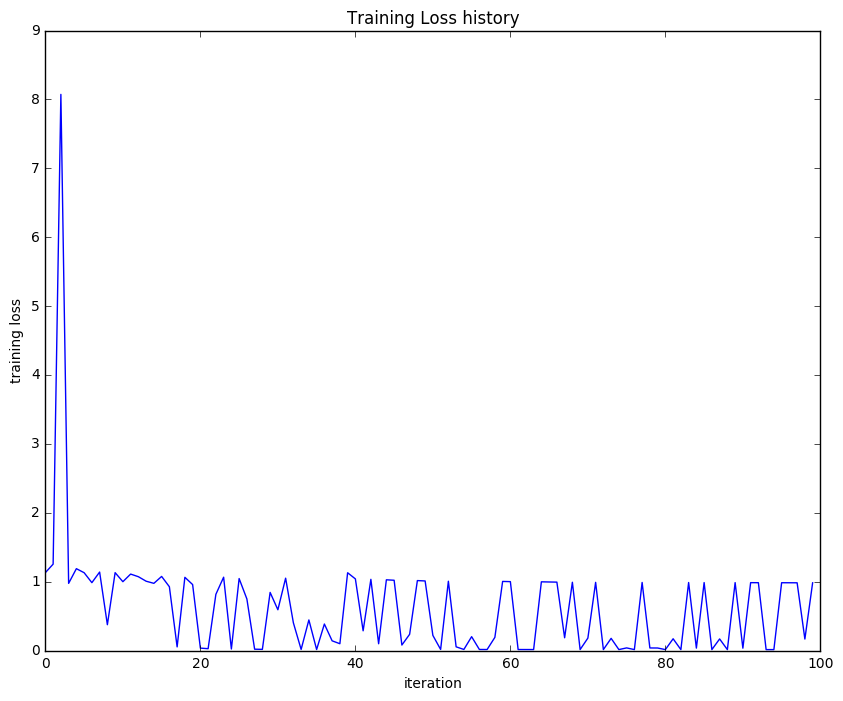

In [6]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=1e-5,
            num_iters=100, verbose=False)

print 'Final training loss: ', stats['loss_history'][-1]

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# Load the data
Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.

In [7]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


# Train a network
To train our network we will use SGD with momentum. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [9]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.5, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print 'Validation accuracy: ', val_acc



Called with 0.0001, 0.95, 0.5, 1000, 200
iteration 0 / 1000: loss 2.302977
iteration 100 / 1000: loss 2.302507
iteration 200 / 1000: loss 2.297981
iteration 300 / 1000: loss 2.246304
iteration 400 / 1000: loss 2.221058
iteration 500 / 1000: loss 2.177207
iteration 600 / 1000: loss 2.080674
iteration 700 / 1000: loss 2.039913
iteration 800 / 1000: loss 2.022969
iteration 900 / 1000: loss 1.973232
Validation accuracy:  0.283


# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.29 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

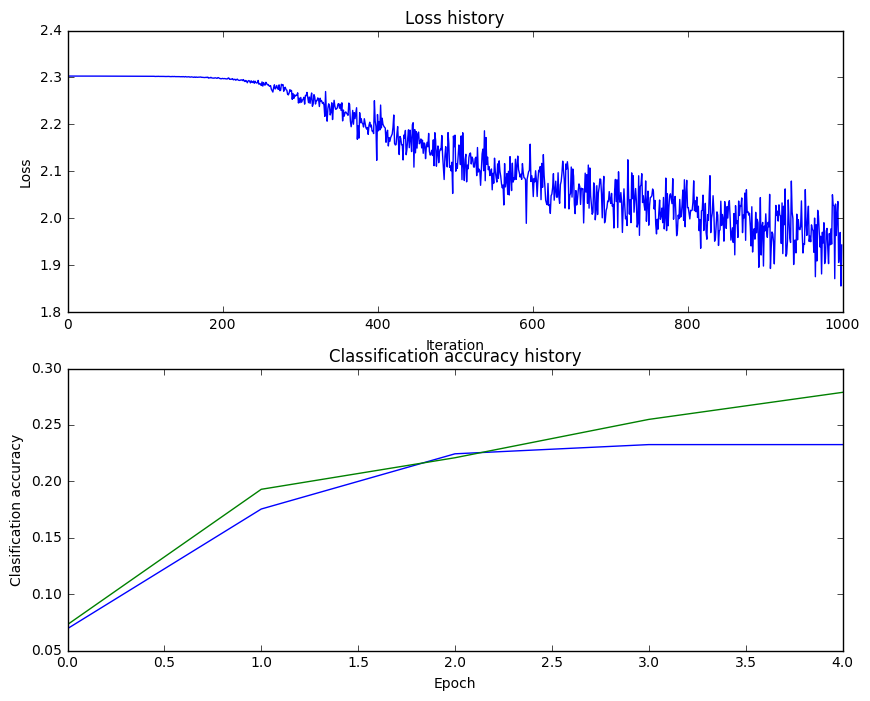

In [10]:
# Plot the loss function and train / validation accuracies
def plot_loss_accuracy():
    plt.subplot(2, 1, 1)
    plt.plot(stats['loss_history'])
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.subplot(2, 1, 2)
    plt.plot(stats['train_acc_history'], label='train')
    plt.plot(stats['val_acc_history'], label='val')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Clasification accuracy')
    plt.show()
    
plot_loss_accuracy()

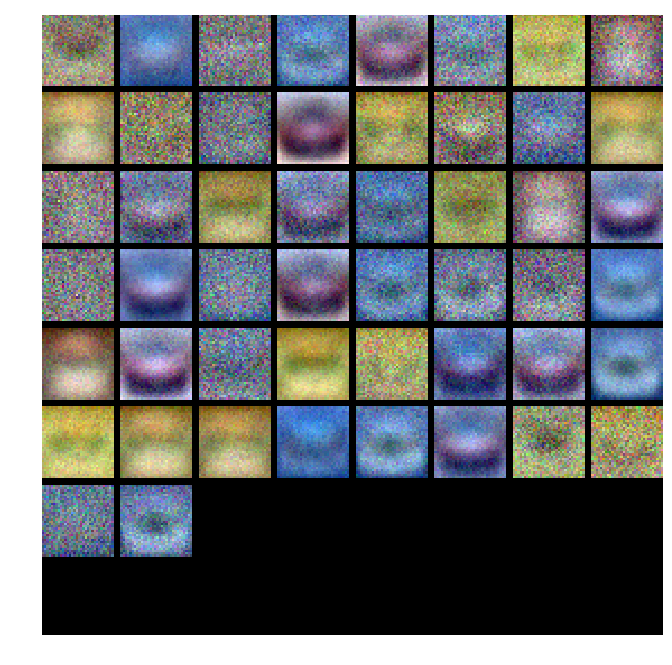

In [11]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
  W1 = net.params['W1']
  W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
  plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
  plt.gca().axis('off')
  plt.show()

show_net_weights(net)

# Tune your hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can, with a fully-connected Neural Network. For every 1% above 52% on the Test set we will award you with one extra bonus point. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

hidden layer size 10
Called with 0.0001, 0.95, 0.5, 1000, 100
iteration 0 / 1000: loss 2.302673
iteration 100 / 1000: loss 2.302583
iteration 200 / 1000: loss 2.301917
iteration 300 / 1000: loss 2.291469
iteration 400 / 1000: loss 2.225891
iteration 500 / 1000: loss 2.169478
iteration 600 / 1000: loss 2.150356
iteration 700 / 1000: loss 2.059589
iteration 800 / 1000: loss 2.031097
iteration 900 / 1000: loss 1.972522
Validation accuracy:  0.275


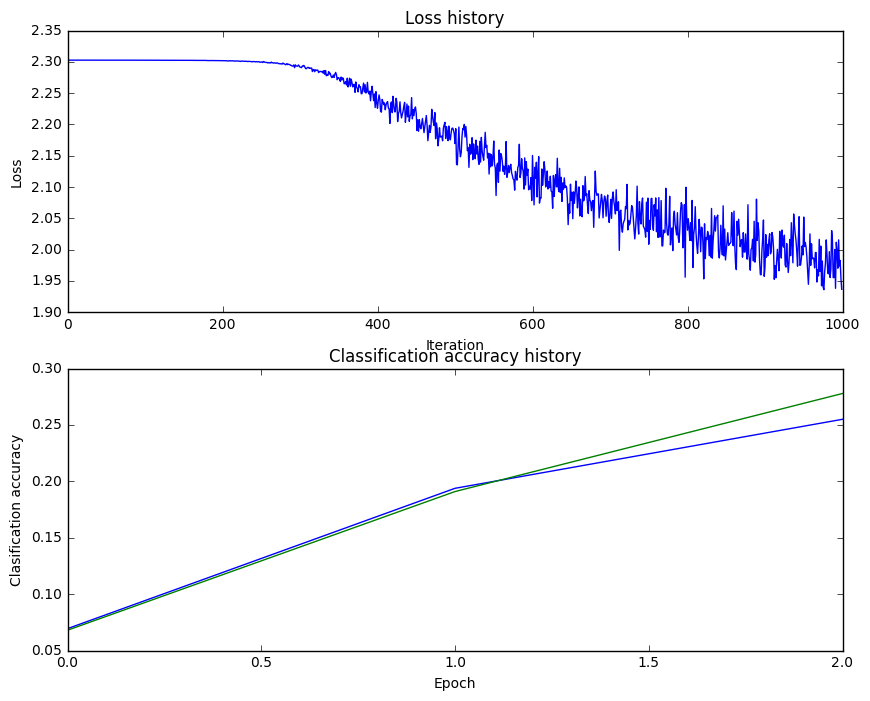

Called with 0.0001, 0.95, 0.5, 1000, 200
iteration 0 / 1000: loss 2.302658
iteration 100 / 1000: loss 2.302588
iteration 200 / 1000: loss 2.301518
iteration 300 / 1000: loss 2.291931
iteration 400 / 1000: loss 2.227347
iteration 500 / 1000: loss 2.183247
iteration 600 / 1000: loss 2.118057
iteration 700 / 1000: loss 2.121515
iteration 800 / 1000: loss 2.016458
iteration 900 / 1000: loss 2.034772
Validation accuracy:  0.256


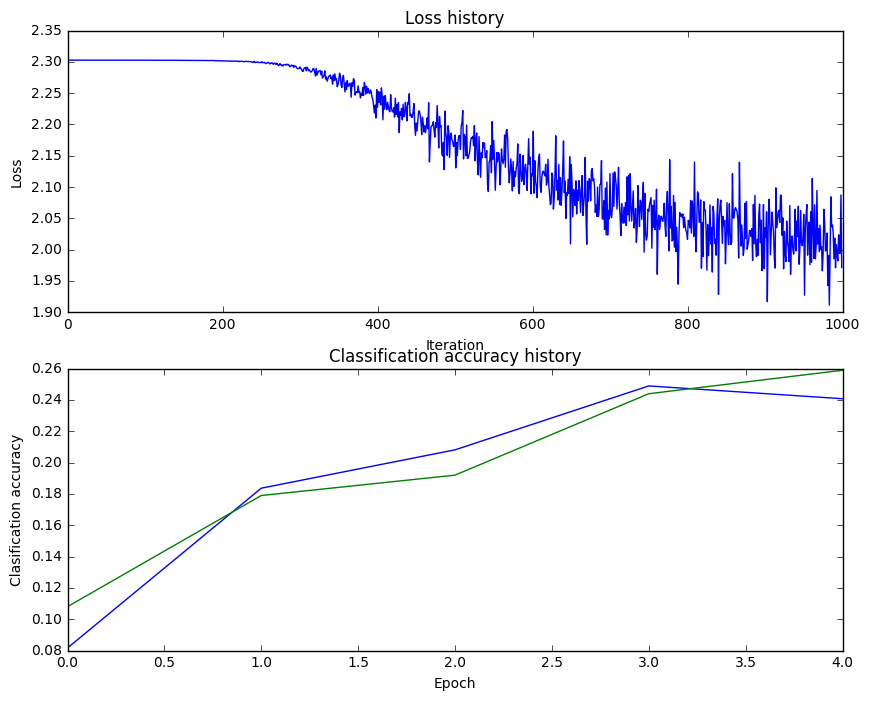

Called with 0.0001, 0.95, 0.5, 1000, 400
iteration 0 / 1000: loss 2.302671
iteration 100 / 1000: loss 2.302620
iteration 200 / 1000: loss 2.302415
iteration 300 / 1000: loss 2.299968
iteration 400 / 1000: loss 2.284644
iteration 500 / 1000: loss 2.254746
iteration 600 / 1000: loss 2.178186
iteration 700 / 1000: loss 2.151707
iteration 800 / 1000: loss 2.173935
iteration 900 / 1000: loss 2.159030
Validation accuracy:  0.222


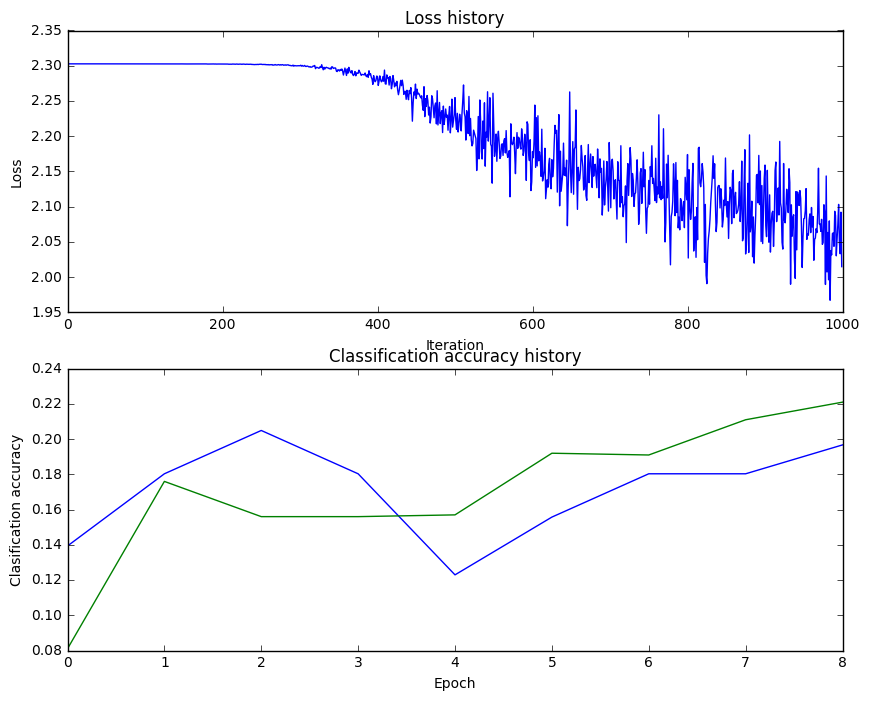

Called with 0.0001, 0.95, 0.5, 1000, 1000
iteration 0 / 1000: loss 2.302662
iteration 100 / 1000: loss 2.302622
iteration 200 / 1000: loss 2.301960
iteration 300 / 1000: loss 2.291769
iteration 400 / 1000: loss 2.245195
iteration 500 / 1000: loss 2.171735
iteration 600 / 1000: loss 2.277647
iteration 700 / 1000: loss 2.204059
iteration 800 / 1000: loss 2.205362
iteration 900 / 1000: loss 2.102819
Validation accuracy:  0.239


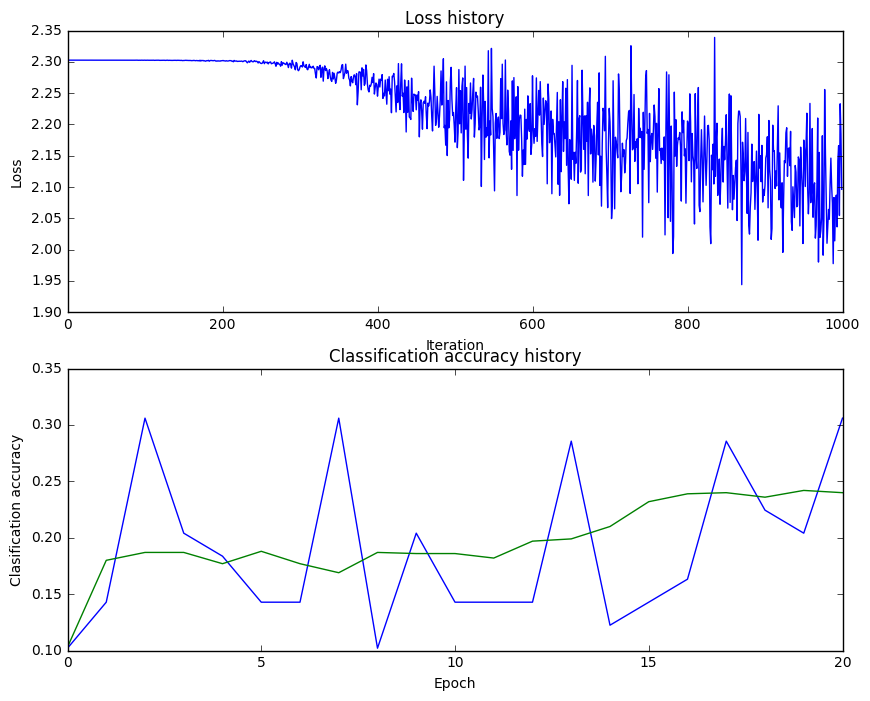

Called with 0.0001, 0.95, 0.5, 2000, 100
iteration 0 / 2000: loss 2.302661
iteration 100 / 2000: loss 2.302560
iteration 200 / 2000: loss 2.301629
iteration 300 / 2000: loss 2.292757
iteration 400 / 2000: loss 2.239323
iteration 500 / 2000: loss 2.161491
iteration 600 / 2000: loss 2.090434
iteration 700 / 2000: loss 2.065126
iteration 800 / 2000: loss 2.068662
iteration 900 / 2000: loss 2.063232
iteration 1000 / 2000: loss 2.037997
iteration 1100 / 2000: loss 1.992082
iteration 1200 / 2000: loss 1.939432
iteration 1300 / 2000: loss 1.907819
iteration 1400 / 2000: loss 1.836542
iteration 1500 / 2000: loss 1.871688
iteration 1600 / 2000: loss 1.824813
iteration 1700 / 2000: loss 1.891552
iteration 1800 / 2000: loss 1.869094
iteration 1900 / 2000: loss 1.801174
Validation accuracy:  0.349


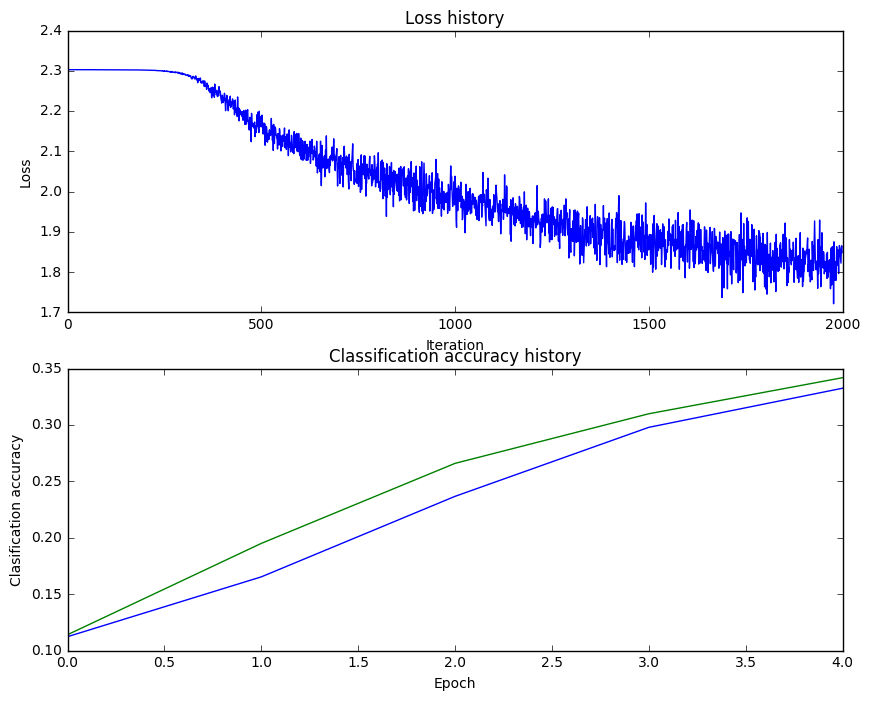

Called with 0.0001, 0.95, 0.5, 2000, 200
iteration 0 / 2000: loss 2.302665
iteration 100 / 2000: loss 2.302600
iteration 200 / 2000: loss 2.301984
iteration 300 / 2000: loss 2.293012
iteration 400 / 2000: loss 2.252626
iteration 500 / 2000: loss 2.203780
iteration 600 / 2000: loss 2.146954
iteration 700 / 2000: loss 2.080172
iteration 800 / 2000: loss 2.042263
iteration 900 / 2000: loss 2.048571
iteration 1000 / 2000: loss 2.011976
iteration 1100 / 2000: loss 1.959423
iteration 1200 / 2000: loss 1.907425
iteration 1300 / 2000: loss 1.894415
iteration 1400 / 2000: loss 1.946279
iteration 1500 / 2000: loss 1.861508
iteration 1600 / 2000: loss 1.881705
iteration 1700 / 2000: loss 1.859055
iteration 1800 / 2000: loss 1.867720
iteration 1900 / 2000: loss 1.838653
Validation accuracy:  0.331


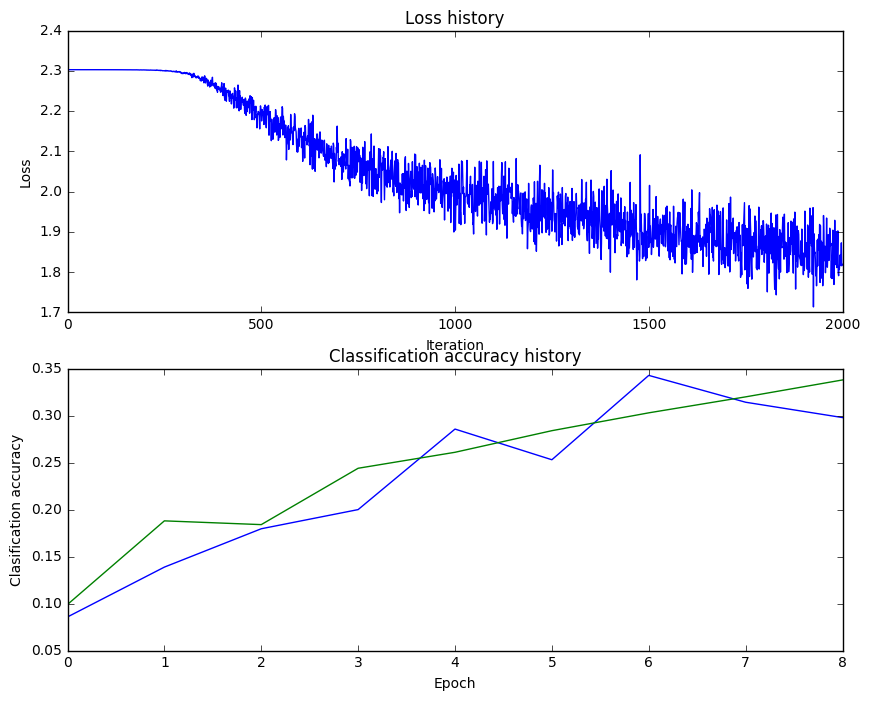

Called with 0.0001, 0.95, 0.5, 2000, 400
iteration 0 / 2000: loss 2.302666
iteration 100 / 2000: loss 2.302587
iteration 200 / 2000: loss 2.301573
iteration 300 / 2000: loss 2.292781
iteration 400 / 2000: loss 2.272445
iteration 500 / 2000: loss 2.195688
iteration 600 / 2000: loss 2.123412
iteration 700 / 2000: loss 2.065682
iteration 800 / 2000: loss 2.175785
iteration 900 / 2000: loss 2.152335
iteration 1000 / 2000: loss 2.015859
iteration 1100 / 2000: loss 2.025855
iteration 1200 / 2000: loss 2.101982
iteration 1300 / 2000: loss 1.947869
iteration 1400 / 2000: loss 1.938625
iteration 1500 / 2000: loss 1.978936
iteration 1600 / 2000: loss 1.931456
iteration 1700 / 2000: loss 1.949469
iteration 1800 / 2000: loss 1.943945
iteration 1900 / 2000: loss 1.892857
Validation accuracy:  0.312


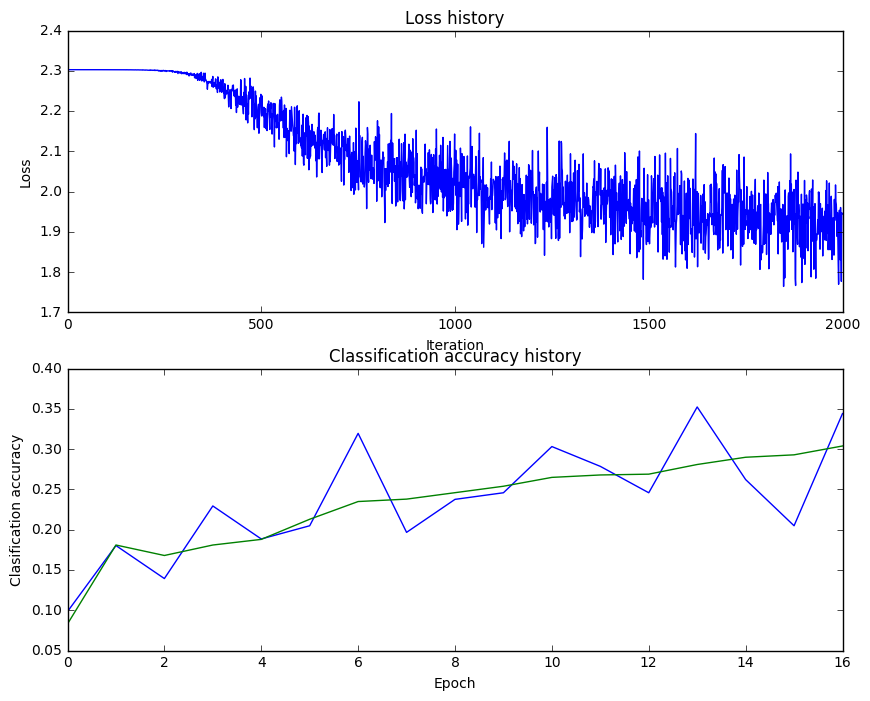

Called with 0.0001, 0.95, 0.5, 2000, 1000
iteration 0 / 2000: loss 2.302651
iteration 100 / 2000: loss 2.302547
iteration 200 / 2000: loss 2.301537
iteration 300 / 2000: loss 2.295190
iteration 400 / 2000: loss 2.281653
iteration 500 / 2000: loss 2.249446
iteration 600 / 2000: loss 2.166119
iteration 700 / 2000: loss 2.163003
iteration 800 / 2000: loss 2.142623
iteration 900 / 2000: loss 2.056537
iteration 1000 / 2000: loss 2.090349
iteration 1100 / 2000: loss 1.955532
iteration 1200 / 2000: loss 2.087236
iteration 1300 / 2000: loss 1.985258
iteration 1400 / 2000: loss 2.057106
iteration 1500 / 2000: loss 2.076951
iteration 1600 / 2000: loss 1.944976
iteration 1700 / 2000: loss 1.894210
iteration 1800 / 2000: loss 2.036531
iteration 1900 / 2000: loss 2.094238
Validation accuracy:  0.246


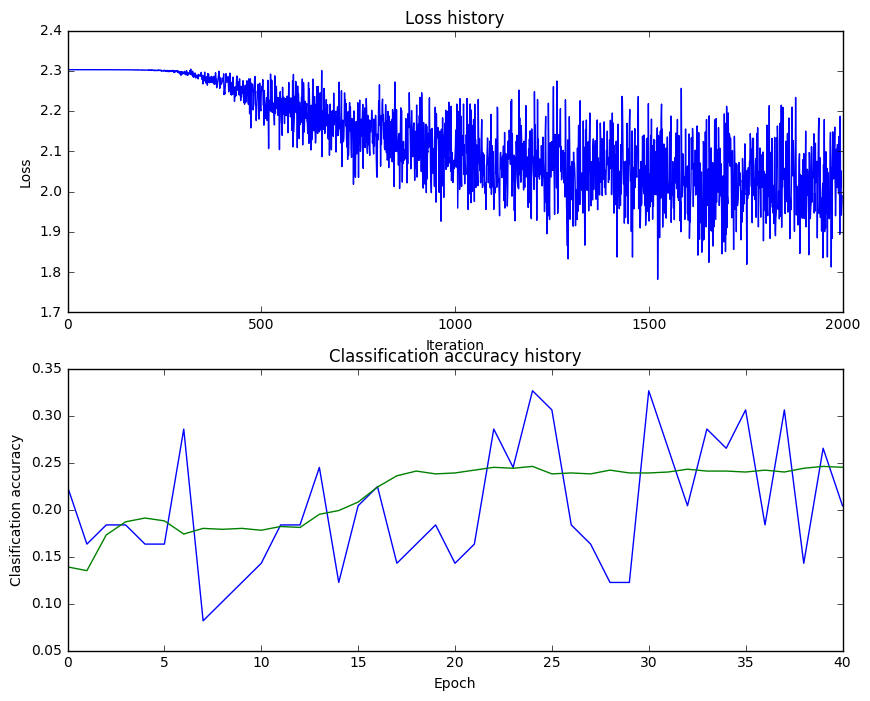

Called with 0.0001, 0.95, 0.5, 4000, 100
iteration 0 / 4000: loss 2.302664
iteration 100 / 4000: loss 2.302547
iteration 200 / 4000: loss 2.301527
iteration 300 / 4000: loss 2.291587
iteration 400 / 4000: loss 2.233528
iteration 500 / 4000: loss 2.187103
iteration 600 / 4000: loss 2.146889
iteration 700 / 4000: loss 2.033275
iteration 800 / 4000: loss 2.052290
iteration 900 / 4000: loss 2.012346
iteration 1000 / 4000: loss 2.016007
iteration 1100 / 4000: loss 1.973676
iteration 1200 / 4000: loss 1.888336
iteration 1300 / 4000: loss 1.914768
iteration 1400 / 4000: loss 1.907246
iteration 1500 / 4000: loss 1.899441
iteration 1600 / 4000: loss 1.852442
iteration 1700 / 4000: loss 1.882779
iteration 1800 / 4000: loss 1.868002
iteration 1900 / 4000: loss 1.900523
iteration 2000 / 4000: loss 1.840234
iteration 2100 / 4000: loss 1.784234
iteration 2200 / 4000: loss 1.867309
iteration 2300 / 4000: loss 1.842258
iteration 2400 / 4000: loss 1.814347
iteration 2500 / 4000: loss 1.874127
iteration

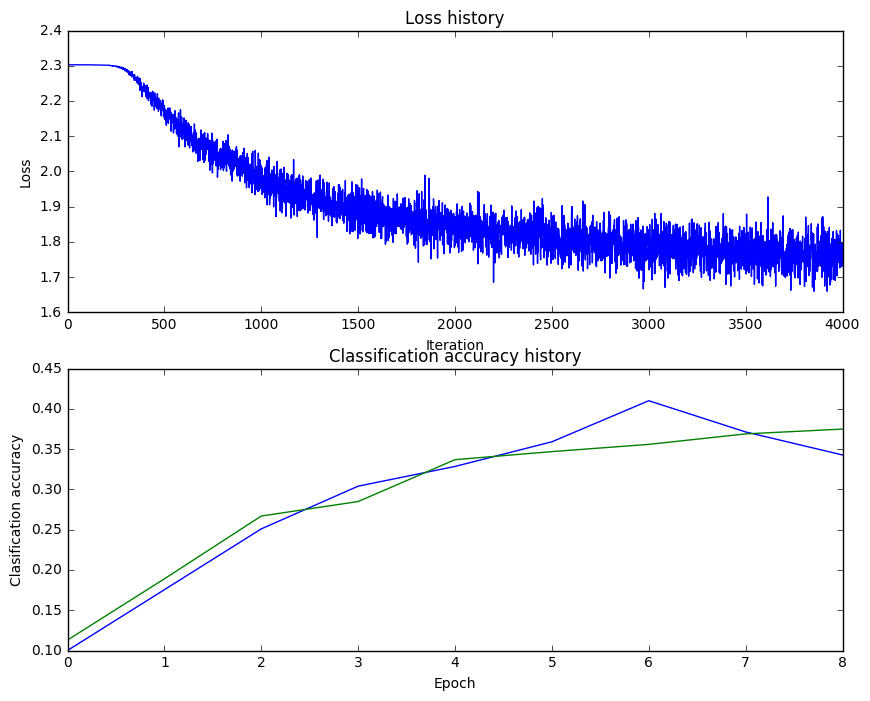

Called with 0.0001, 0.95, 0.5, 4000, 200
iteration 0 / 4000: loss 2.302663
iteration 100 / 4000: loss 2.302582
iteration 200 / 4000: loss 2.301978
iteration 300 / 4000: loss 2.294764
iteration 400 / 4000: loss 2.264198
iteration 500 / 4000: loss 2.196746
iteration 600 / 4000: loss 2.143553
iteration 700 / 4000: loss 2.077887
iteration 800 / 4000: loss 2.083569
iteration 900 / 4000: loss 2.087788
iteration 1000 / 4000: loss 1.993807
iteration 1100 / 4000: loss 1.987789
iteration 1200 / 4000: loss 1.917779
iteration 1300 / 4000: loss 1.907160
iteration 1400 / 4000: loss 1.886680
iteration 1500 / 4000: loss 1.834737
iteration 1600 / 4000: loss 1.958318
iteration 1700 / 4000: loss 1.855979
iteration 1800 / 4000: loss 1.824681
iteration 1900 / 4000: loss 1.845674
iteration 2000 / 4000: loss 1.848730
iteration 2100 / 4000: loss 1.919227
iteration 2200 / 4000: loss 1.790569
iteration 2300 / 4000: loss 1.901104
iteration 2400 / 4000: loss 1.888570
iteration 2500 / 4000: loss 1.804891
iteration

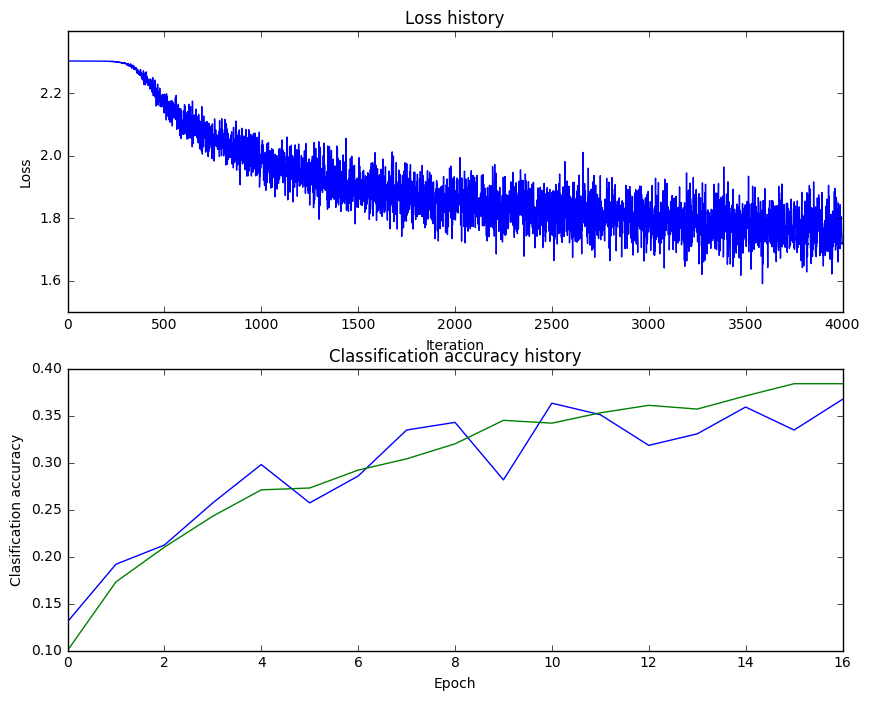

Called with 0.0001, 0.95, 0.5, 4000, 400
iteration 0 / 4000: loss 2.302669
iteration 100 / 4000: loss 2.302611
iteration 200 / 4000: loss 2.302071
iteration 300 / 4000: loss 2.298134
iteration 400 / 4000: loss 2.256035
iteration 500 / 4000: loss 2.222376
iteration 600 / 4000: loss 2.137668
iteration 700 / 4000: loss 2.115639
iteration 800 / 4000: loss 2.132974
iteration 900 / 4000: loss 2.026649
iteration 1000 / 4000: loss 2.109909
iteration 1100 / 4000: loss 2.046338
iteration 1200 / 4000: loss 2.017895
iteration 1300 / 4000: loss 1.890126
iteration 1400 / 4000: loss 1.922210
iteration 1500 / 4000: loss 1.968143
iteration 1600 / 4000: loss 2.033352
iteration 1700 / 4000: loss 1.822629
iteration 1800 / 4000: loss 1.865725
iteration 1900 / 4000: loss 1.900089
iteration 2000 / 4000: loss 1.813302
iteration 2100 / 4000: loss 1.848790
iteration 2200 / 4000: loss 1.876828
iteration 2300 / 4000: loss 1.915675
iteration 2400 / 4000: loss 1.786022
iteration 2500 / 4000: loss 1.906482
iteration

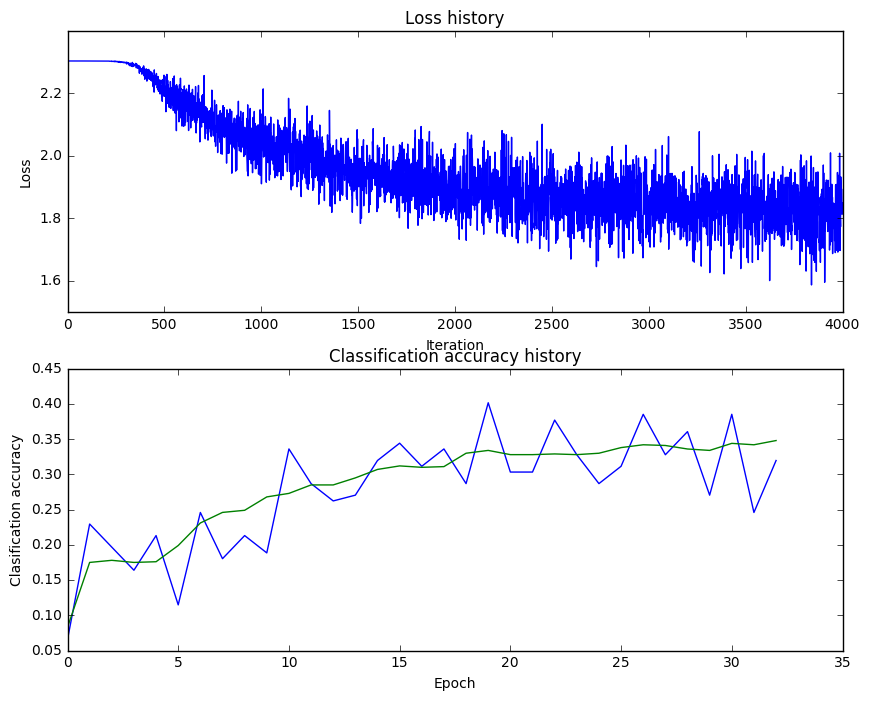

Called with 0.0001, 0.95, 0.5, 4000, 1000
iteration 0 / 4000: loss 2.302679
iteration 100 / 4000: loss 2.302650
iteration 200 / 4000: loss 2.302396
iteration 300 / 4000: loss 2.301772
iteration 400 / 4000: loss 2.294446
iteration 500 / 4000: loss 2.270757
iteration 600 / 4000: loss 2.166098
iteration 700 / 4000: loss 2.153222
iteration 800 / 4000: loss 2.066934
iteration 900 / 4000: loss 2.162128
iteration 1000 / 4000: loss 2.089787
iteration 1100 / 4000: loss 2.151712
iteration 1200 / 4000: loss 2.036607
iteration 1300 / 4000: loss 2.049580
iteration 1400 / 4000: loss 2.034692
iteration 1500 / 4000: loss 2.217330
iteration 1600 / 4000: loss 2.089891
iteration 1700 / 4000: loss 2.086970
iteration 1800 / 4000: loss 2.067840
iteration 1900 / 4000: loss 2.026562
iteration 2000 / 4000: loss 1.995128
iteration 2100 / 4000: loss 1.988430
iteration 2200 / 4000: loss 2.179955
iteration 2300 / 4000: loss 2.024204
iteration 2400 / 4000: loss 1.985103
iteration 2500 / 4000: loss 1.973320
iteratio

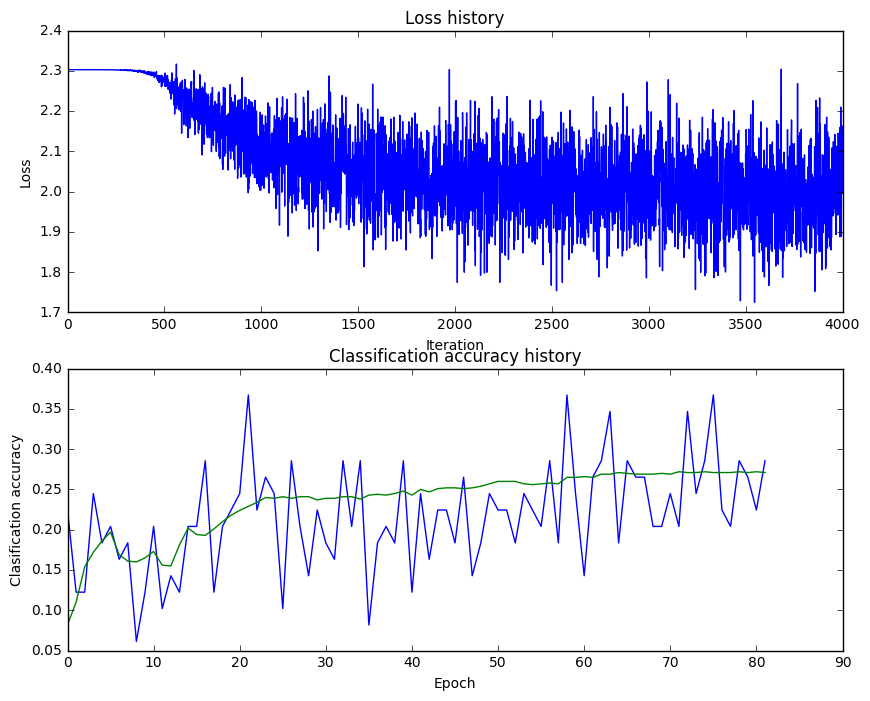

Called with 0.0001, 0.95, 0.5, 10000, 100
iteration 0 / 10000: loss 2.302659
iteration 100 / 10000: loss 2.302613
iteration 200 / 10000: loss 2.302280
iteration 300 / 10000: loss 2.298114
iteration 400 / 10000: loss 2.259892
iteration 500 / 10000: loss 2.201273
iteration 600 / 10000: loss 2.120419
iteration 700 / 10000: loss 2.116231
iteration 800 / 10000: loss 2.061117
iteration 900 / 10000: loss 2.042115
iteration 1000 / 10000: loss 1.988940
iteration 1100 / 10000: loss 1.993461
iteration 1200 / 10000: loss 1.947306
iteration 1300 / 10000: loss 1.955249
iteration 1400 / 10000: loss 1.949550
iteration 1500 / 10000: loss 1.856677
iteration 1600 / 10000: loss 1.850508
iteration 1700 / 10000: loss 1.887231
iteration 1800 / 10000: loss 1.840448
iteration 1900 / 10000: loss 1.797972
iteration 2000 / 10000: loss 1.803668
iteration 2100 / 10000: loss 1.838843
iteration 2200 / 10000: loss 1.727795
iteration 2300 / 10000: loss 1.815270
iteration 2400 / 10000: loss 1.722361
iteration 2500 / 100

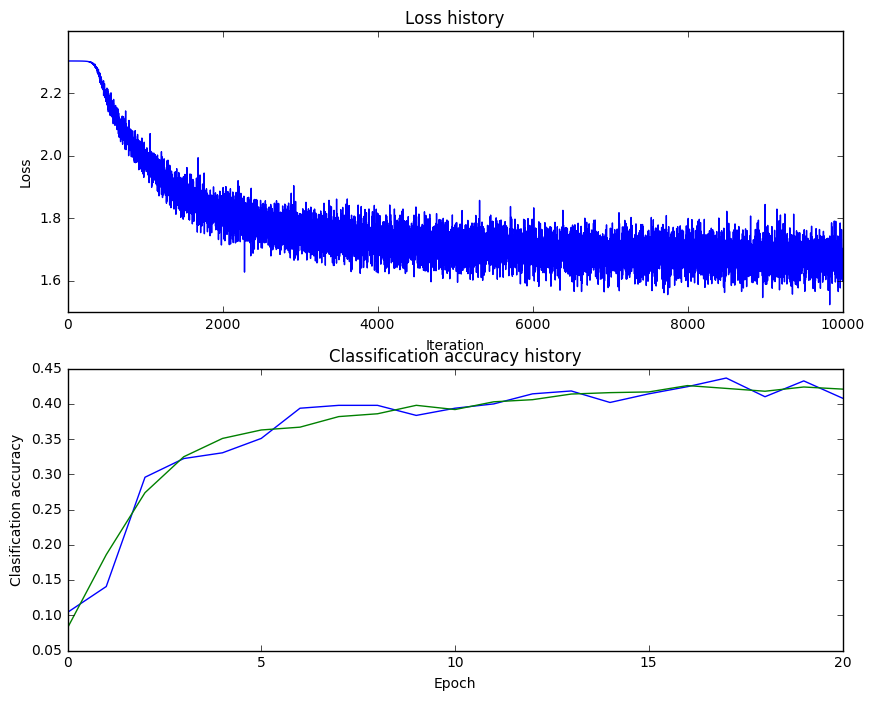

Called with 0.0001, 0.95, 0.5, 10000, 200
iteration 0 / 10000: loss 2.302664
iteration 100 / 10000: loss 2.302591
iteration 200 / 10000: loss 2.301661
iteration 300 / 10000: loss 2.290742
iteration 400 / 10000: loss 2.240842
iteration 500 / 10000: loss 2.191854
iteration 600 / 10000: loss 2.166076
iteration 700 / 10000: loss 2.103681
iteration 800 / 10000: loss 2.083853
iteration 900 / 10000: loss 2.024232
iteration 1000 / 10000: loss 2.114424
iteration 1100 / 10000: loss 2.013443
iteration 1200 / 10000: loss 1.991814
iteration 1300 / 10000: loss 1.974357
iteration 1400 / 10000: loss 1.978034
iteration 1500 / 10000: loss 1.897673
iteration 1600 / 10000: loss 1.759708
iteration 1700 / 10000: loss 1.823022
iteration 1800 / 10000: loss 1.865063
iteration 1900 / 10000: loss 1.821641
iteration 2000 / 10000: loss 1.803415
iteration 2100 / 10000: loss 1.841350
iteration 2200 / 10000: loss 1.849324
iteration 2300 / 10000: loss 1.762033
iteration 2400 / 10000: loss 1.798585
iteration 2500 / 100

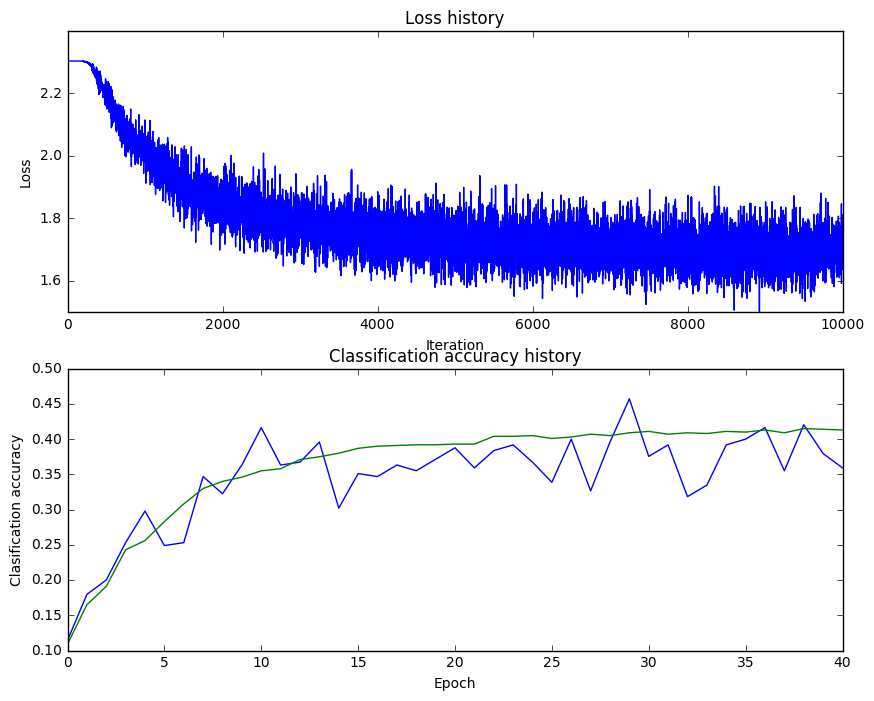

Called with 0.0001, 0.95, 0.5, 10000, 400
iteration 0 / 10000: loss 2.302661
iteration 100 / 10000: loss 2.302556
iteration 200 / 10000: loss 2.301353
iteration 300 / 10000: loss 2.293954
iteration 400 / 10000: loss 2.269962
iteration 500 / 10000: loss 2.216643
iteration 600 / 10000: loss 2.110700
iteration 700 / 10000: loss 2.041821
iteration 800 / 10000: loss 2.028571
iteration 900 / 10000: loss 2.019211
iteration 1000 / 10000: loss 2.081553
iteration 1100 / 10000: loss 2.147993
iteration 1200 / 10000: loss 2.090347
iteration 1300 / 10000: loss 1.952879
iteration 1400 / 10000: loss 1.911305
iteration 1500 / 10000: loss 2.021142
iteration 1600 / 10000: loss 1.967569
iteration 1700 / 10000: loss 1.997671
iteration 1800 / 10000: loss 1.871621
iteration 1900 / 10000: loss 1.905536
iteration 2000 / 10000: loss 1.931741
iteration 2100 / 10000: loss 1.878119
iteration 2200 / 10000: loss 1.961076
iteration 2300 / 10000: loss 1.876634
iteration 2400 / 10000: loss 1.973370
iteration 2500 / 100

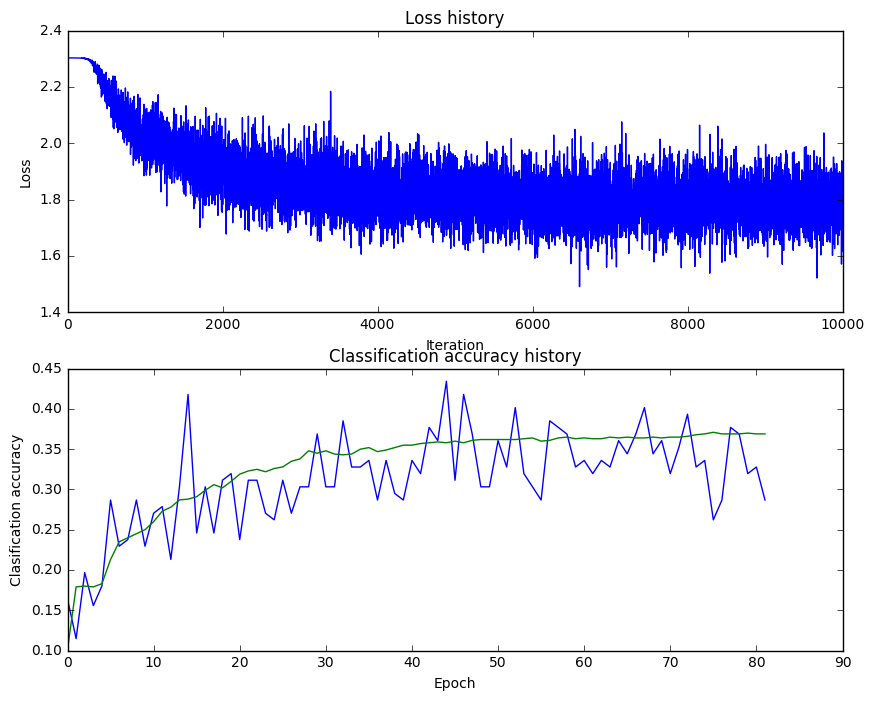

Called with 0.0001, 0.95, 0.5, 10000, 1000
iteration 0 / 10000: loss 2.302660
iteration 100 / 10000: loss 2.302523
iteration 200 / 10000: loss 2.301580
iteration 300 / 10000: loss 2.296911
iteration 400 / 10000: loss 2.291225
iteration 500 / 10000: loss 2.190414
iteration 600 / 10000: loss 2.215175
iteration 700 / 10000: loss 2.101298
iteration 800 / 10000: loss 2.220274
iteration 900 / 10000: loss 2.256984
iteration 1000 / 10000: loss 2.128666
iteration 1100 / 10000: loss 2.093561
iteration 1200 / 10000: loss 1.990737
iteration 1300 / 10000: loss 2.044805
iteration 1400 / 10000: loss 2.060369
iteration 1500 / 10000: loss 2.017514
iteration 1600 / 10000: loss 2.038459
iteration 1700 / 10000: loss 2.136250
iteration 1800 / 10000: loss 2.038039
iteration 1900 / 10000: loss 2.024498
iteration 2000 / 10000: loss 1.946843
iteration 2100 / 10000: loss 2.155983
iteration 2200 / 10000: loss 2.014706
iteration 2300 / 10000: loss 1.979463
iteration 2400 / 10000: loss 1.867897
iteration 2500 / 10

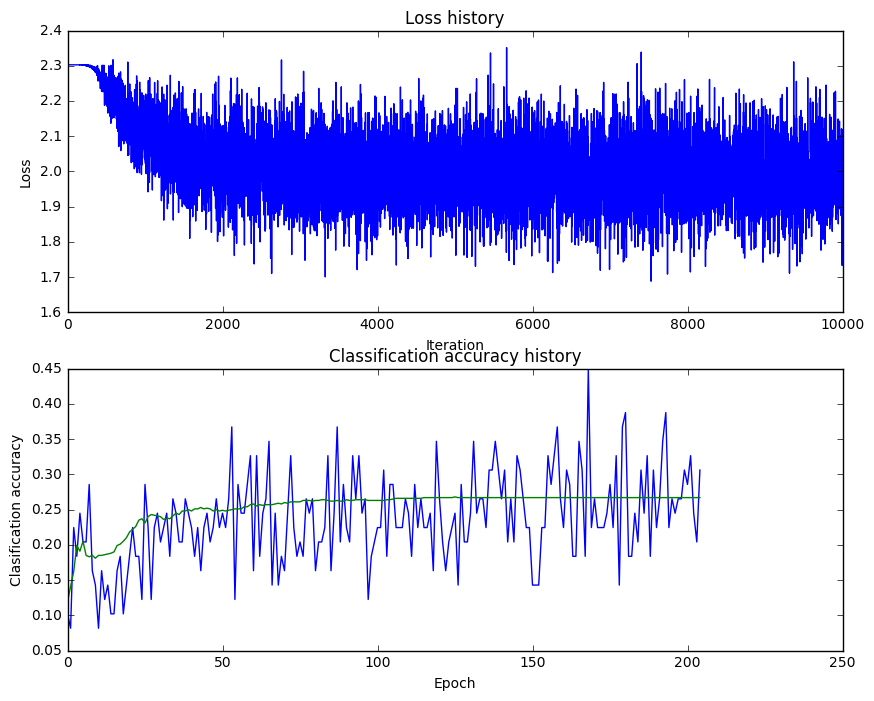

hidden layer size 100
Called with 0.0001, 0.95, 0.5, 1000, 100
iteration 0 / 1000: loss 2.303332
iteration 100 / 1000: loss 2.302555
iteration 200 / 1000: loss 2.293809
iteration 300 / 1000: loss 2.232956
iteration 400 / 1000: loss 2.142227
iteration 500 / 1000: loss 2.063098
iteration 600 / 1000: loss 2.101841
iteration 700 / 1000: loss 2.025215
iteration 800 / 1000: loss 2.021842
iteration 900 / 1000: loss 1.972962
Validation accuracy:  0.296


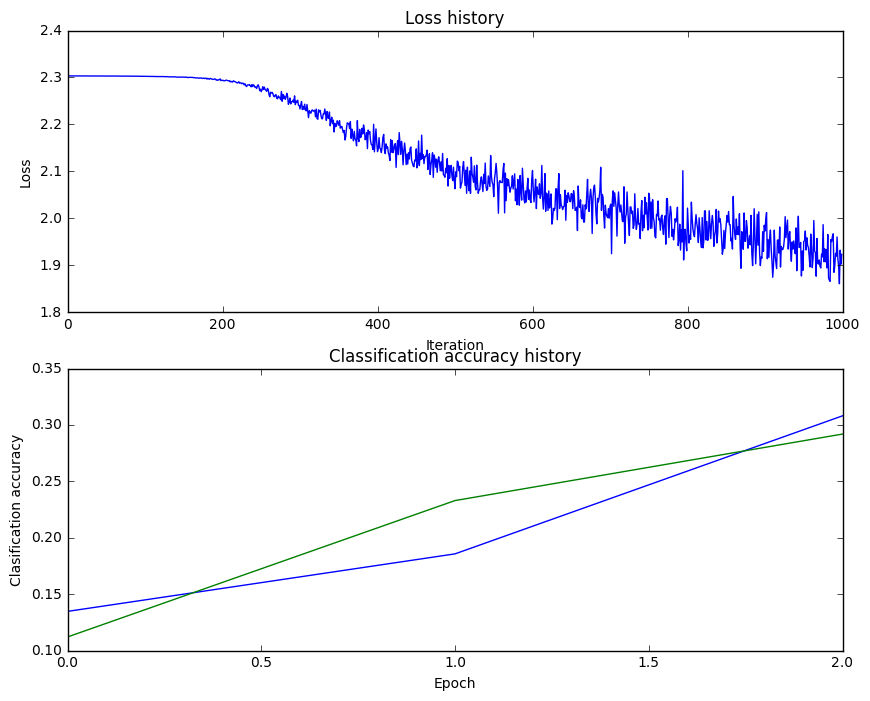

Called with 0.0001, 0.95, 0.5, 1000, 200
iteration 0 / 1000: loss 2.303346
iteration 100 / 1000: loss 2.302218
iteration 200 / 1000: loss 2.290558
iteration 300 / 1000: loss 2.249121
iteration 400 / 1000: loss 2.198106
iteration 500 / 1000: loss 2.100670
iteration 600 / 1000: loss 2.056413
iteration 700 / 1000: loss 2.071870
iteration 800 / 1000: loss 1.995024
iteration 900 / 1000: loss 1.904517
Validation accuracy:  0.29


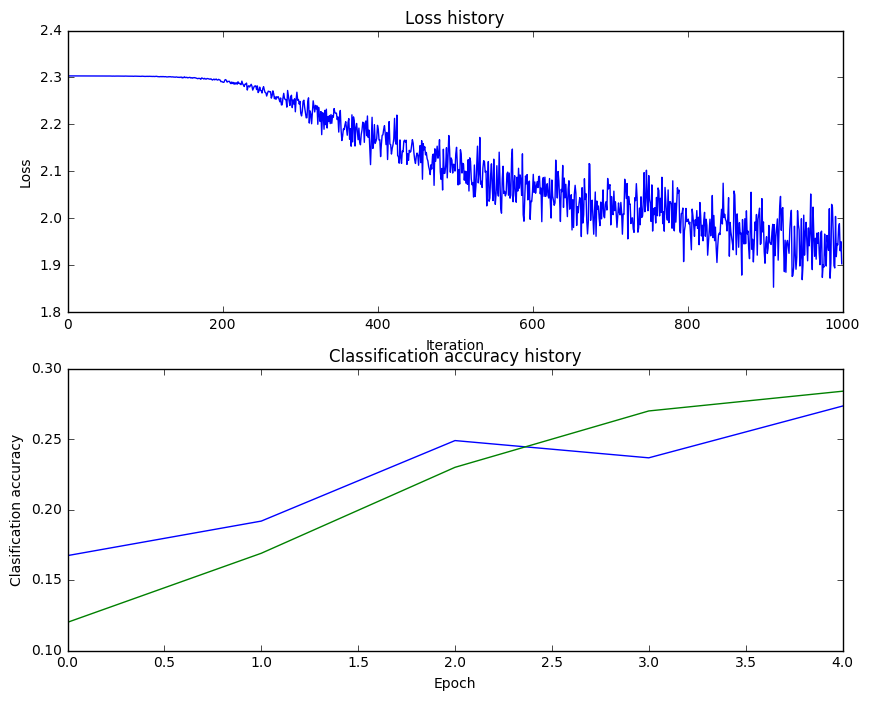

Called with 0.0001, 0.95, 0.5, 1000, 400
iteration 0 / 1000: loss 2.303338
iteration 100 / 1000: loss 2.302358
iteration 200 / 1000: loss 2.292022
iteration 300 / 1000: loss 2.245191
iteration 400 / 1000: loss 2.164532
iteration 500 / 1000: loss 2.108598
iteration 600 / 1000: loss 2.086934
iteration 700 / 1000: loss 1.941339
iteration 800 / 1000: loss 2.024447
iteration 900 / 1000: loss 2.007935
Validation accuracy:  0.281


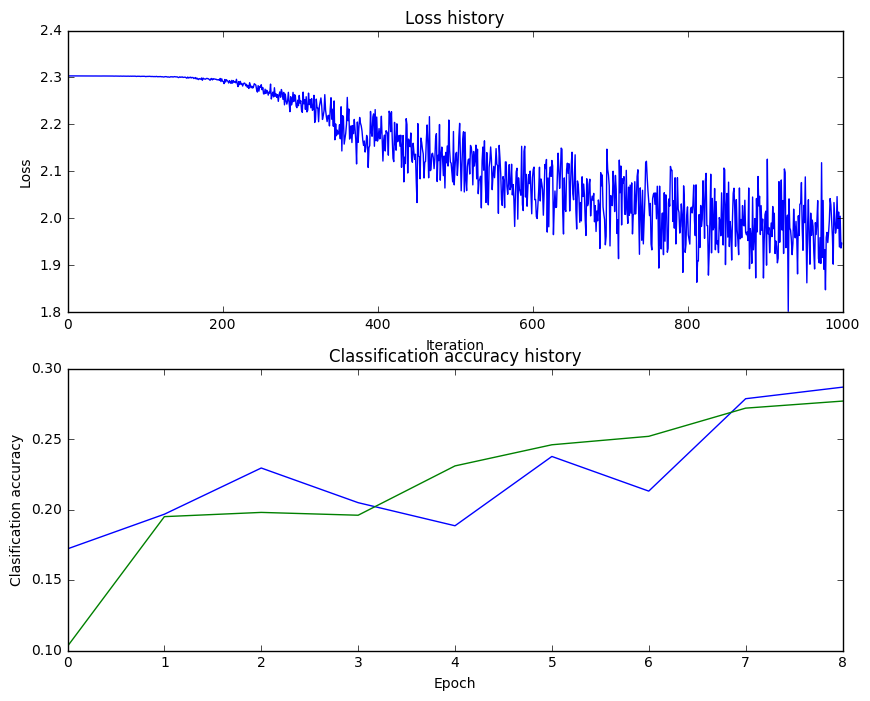

Called with 0.0001, 0.95, 0.5, 1000, 1000
iteration 0 / 1000: loss 2.303313
iteration 100 / 1000: loss 2.302450
iteration 200 / 1000: loss 2.295632
iteration 300 / 1000: loss 2.275145
iteration 400 / 1000: loss 2.256554
iteration 500 / 1000: loss 2.130370
iteration 600 / 1000: loss 2.226215
iteration 700 / 1000: loss 2.072153
iteration 800 / 1000: loss 2.110888
iteration 900 / 1000: loss 2.031773
Validation accuracy:  0.25


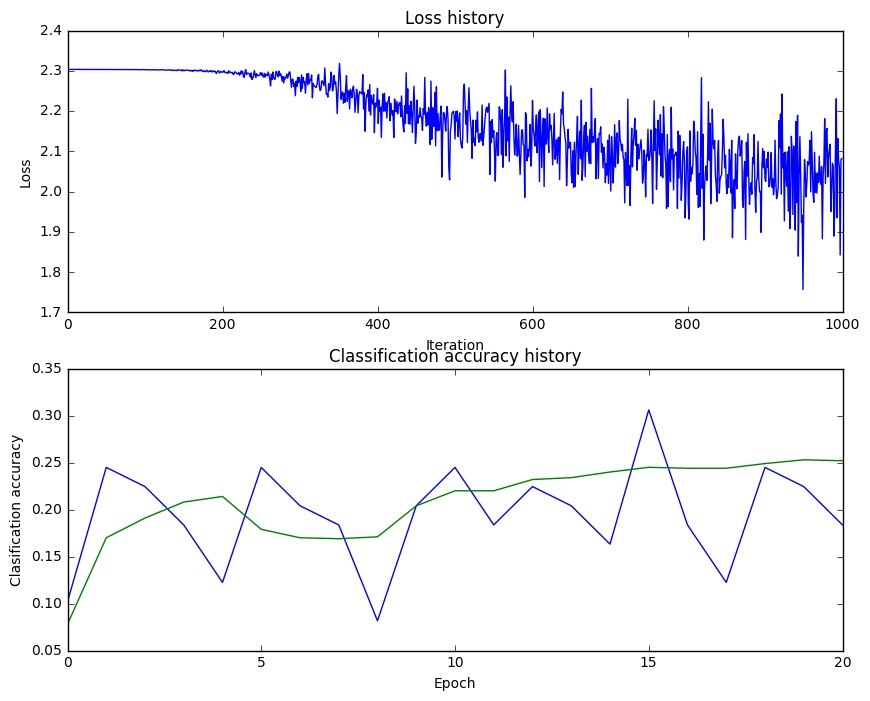

Called with 0.0001, 0.95, 0.5, 2000, 100
iteration 0 / 2000: loss 2.303334
iteration 100 / 2000: loss 2.302261
iteration 200 / 2000: loss 2.292275
iteration 300 / 2000: loss 2.231616
iteration 400 / 2000: loss 2.160910
iteration 500 / 2000: loss 2.106159
iteration 600 / 2000: loss 2.038549
iteration 700 / 2000: loss 2.004830
iteration 800 / 2000: loss 2.000312
iteration 900 / 2000: loss 1.923197
iteration 1000 / 2000: loss 1.911974
iteration 1100 / 2000: loss 1.967386
iteration 1200 / 2000: loss 1.955594
iteration 1300 / 2000: loss 1.826271
iteration 1400 / 2000: loss 1.820326
iteration 1500 / 2000: loss 1.780986
iteration 1600 / 2000: loss 1.760165
iteration 1700 / 2000: loss 1.803503
iteration 1800 / 2000: loss 1.821620
iteration 1900 / 2000: loss 1.808951
Validation accuracy:  0.37


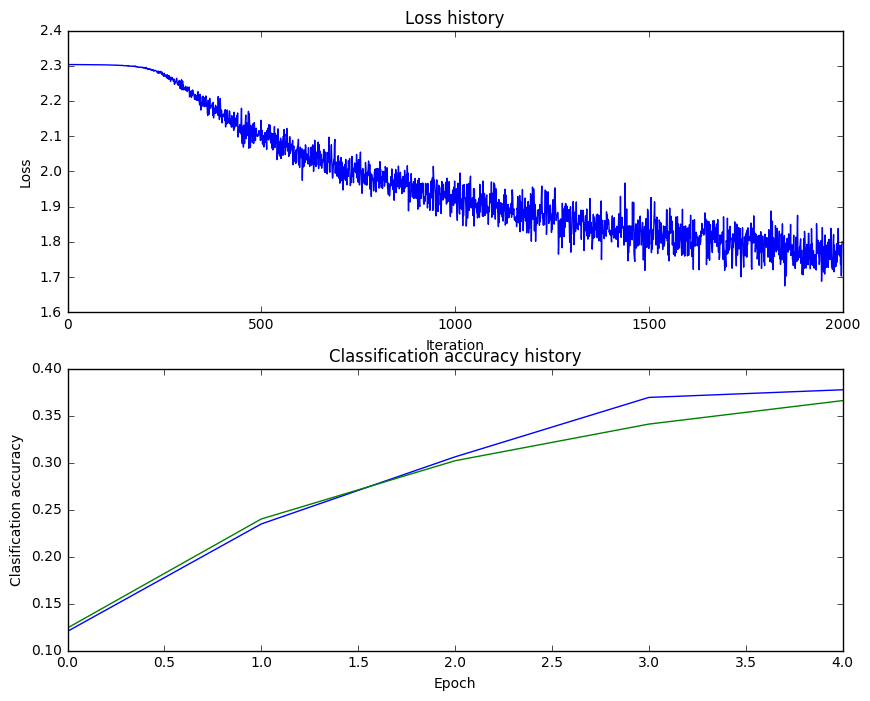

Called with 0.0001, 0.95, 0.5, 2000, 200
iteration 0 / 2000: loss 2.303369
iteration 100 / 2000: loss 2.302386
iteration 200 / 2000: loss 2.293240
iteration 300 / 2000: loss 2.237144
iteration 400 / 2000: loss 2.148897
iteration 500 / 2000: loss 2.080580
iteration 600 / 2000: loss 2.040047
iteration 700 / 2000: loss 1.980239
iteration 800 / 2000: loss 2.005381
iteration 900 / 2000: loss 1.944488
iteration 1000 / 2000: loss 1.975370
iteration 1100 / 2000: loss 1.936420
iteration 1200 / 2000: loss 1.885085
iteration 1300 / 2000: loss 1.888233
iteration 1400 / 2000: loss 1.807226
iteration 1500 / 2000: loss 1.774773
iteration 1600 / 2000: loss 1.883142
iteration 1700 / 2000: loss 1.839474
iteration 1800 / 2000: loss 1.778394
iteration 1900 / 2000: loss 1.822723
Validation accuracy:  0.376


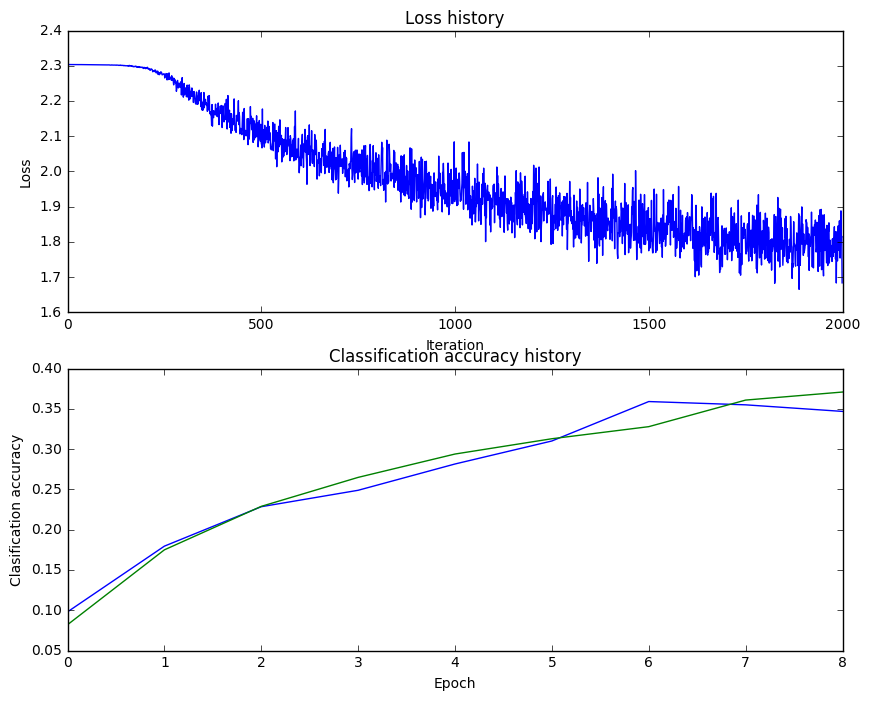

Called with 0.0001, 0.95, 0.5, 2000, 400
iteration 0 / 2000: loss 2.303399
iteration 100 / 2000: loss 2.302380
iteration 200 / 2000: loss 2.295710
iteration 300 / 2000: loss 2.243307
iteration 400 / 2000: loss 2.177341
iteration 500 / 2000: loss 2.100117
iteration 600 / 2000: loss 2.082663
iteration 700 / 2000: loss 2.109367
iteration 800 / 2000: loss 2.094857
iteration 900 / 2000: loss 1.958615
iteration 1000 / 2000: loss 1.960412
iteration 1100 / 2000: loss 1.843841
iteration 1200 / 2000: loss 1.898483
iteration 1300 / 2000: loss 1.969956
iteration 1400 / 2000: loss 1.855781
iteration 1500 / 2000: loss 1.801587
iteration 1600 / 2000: loss 1.861309
iteration 1700 / 2000: loss 1.808976
iteration 1800 / 2000: loss 1.936769
iteration 1900 / 2000: loss 1.847732
Validation accuracy:  0.342


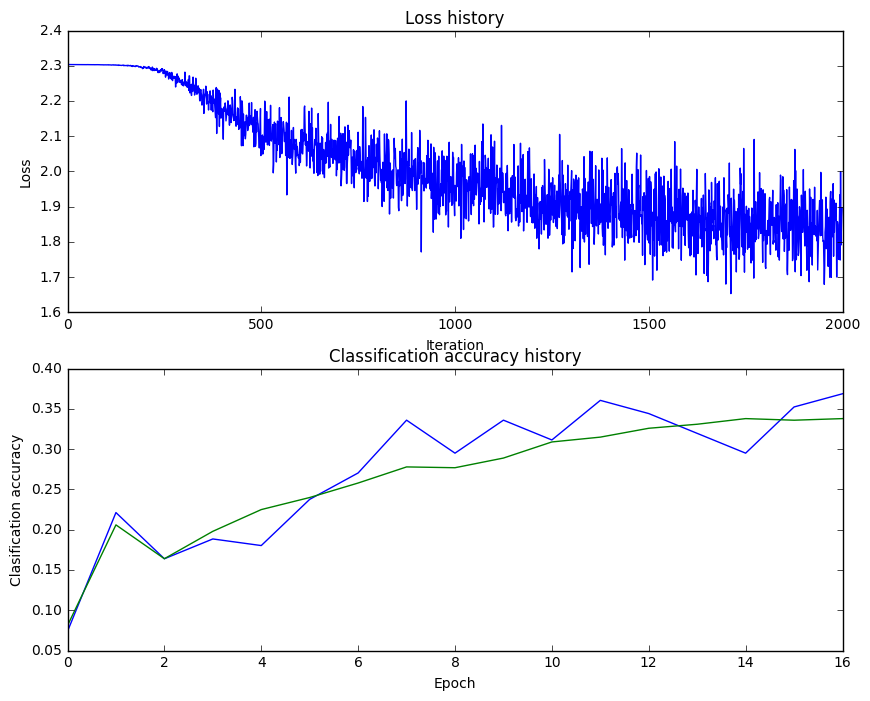

Called with 0.0001, 0.95, 0.5, 2000, 1000
iteration 0 / 2000: loss 2.303371
iteration 100 / 2000: loss 2.302895
iteration 200 / 2000: loss 2.297378
iteration 300 / 2000: loss 2.251505
iteration 400 / 2000: loss 2.218026
iteration 500 / 2000: loss 2.124953
iteration 600 / 2000: loss 2.074279
iteration 700 / 2000: loss 2.196645
iteration 800 / 2000: loss 2.025207
iteration 900 / 2000: loss 2.067761
iteration 1000 / 2000: loss 2.165023
iteration 1100 / 2000: loss 1.886002
iteration 1200 / 2000: loss 1.925232
iteration 1300 / 2000: loss 2.101934
iteration 1400 / 2000: loss 2.091293
iteration 1500 / 2000: loss 1.861259
iteration 1600 / 2000: loss 2.101756
iteration 1700 / 2000: loss 2.005360
iteration 1800 / 2000: loss 1.994669
iteration 1900 / 2000: loss 2.024275
Validation accuracy:  0.285


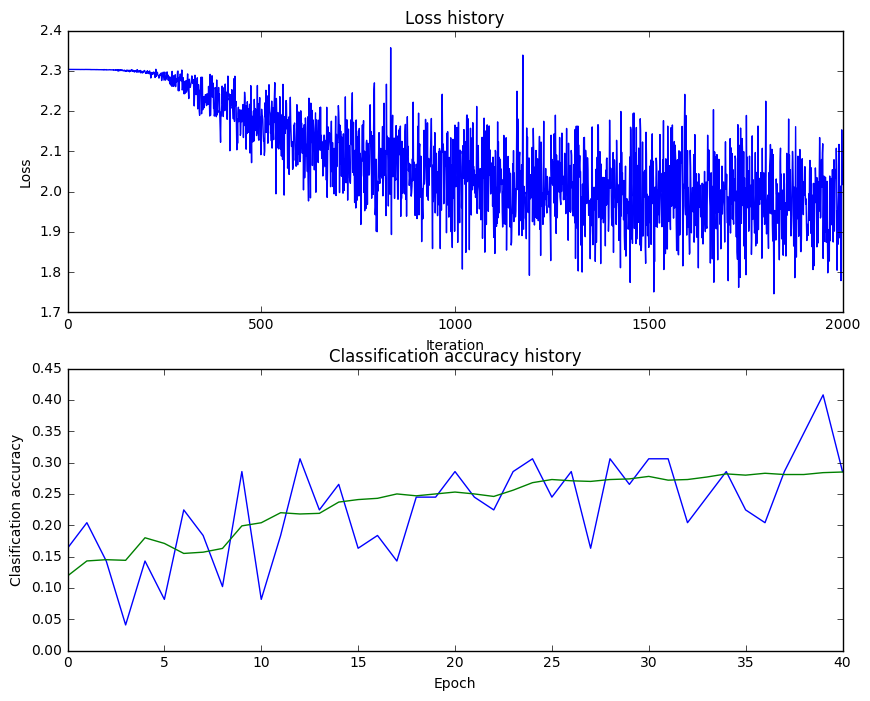

Called with 0.0001, 0.95, 0.5, 4000, 100
iteration 0 / 4000: loss 2.303369
iteration 100 / 4000: loss 2.302546
iteration 200 / 4000: loss 2.293959
iteration 300 / 4000: loss 2.245596
iteration 400 / 4000: loss 2.177014
iteration 500 / 4000: loss 2.077677
iteration 600 / 4000: loss 2.033901
iteration 700 / 4000: loss 1.997363
iteration 800 / 4000: loss 2.026794
iteration 900 / 4000: loss 1.932616
iteration 1000 / 4000: loss 1.936976
iteration 1100 / 4000: loss 1.897442
iteration 1200 / 4000: loss 1.923554
iteration 1300 / 4000: loss 1.861373
iteration 1400 / 4000: loss 1.842404
iteration 1500 / 4000: loss 1.847477
iteration 1600 / 4000: loss 1.784155
iteration 1700 / 4000: loss 1.785480
iteration 1800 / 4000: loss 1.747745
iteration 1900 / 4000: loss 1.714231
iteration 2000 / 4000: loss 1.781030
iteration 2100 / 4000: loss 1.757655
iteration 2200 / 4000: loss 1.710856
iteration 2300 / 4000: loss 1.702000
iteration 2400 / 4000: loss 1.742563
iteration 2500 / 4000: loss 1.681832
iteration

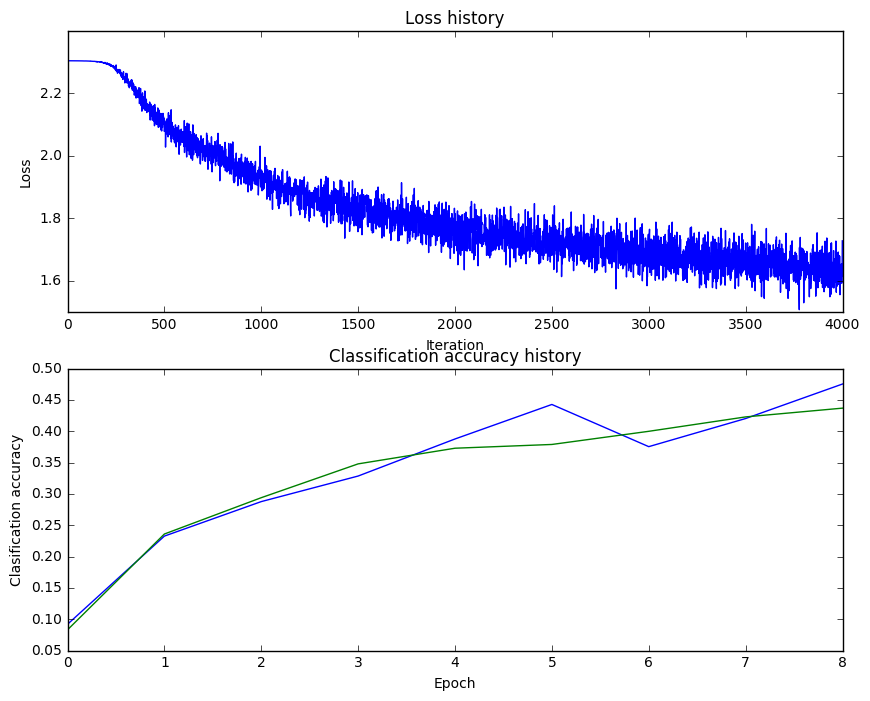

Called with 0.0001, 0.95, 0.5, 4000, 200
iteration 0 / 4000: loss 2.303334
iteration 100 / 4000: loss 2.302269
iteration 200 / 4000: loss 2.290323
iteration 300 / 4000: loss 2.236615
iteration 400 / 4000: loss 2.131283
iteration 500 / 4000: loss 2.119177
iteration 600 / 4000: loss 2.085783
iteration 700 / 4000: loss 2.010188
iteration 800 / 4000: loss 1.975694
iteration 900 / 4000: loss 1.950887
iteration 1000 / 4000: loss 1.932059
iteration 1100 / 4000: loss 1.868158
iteration 1200 / 4000: loss 1.906066
iteration 1300 / 4000: loss 1.787220
iteration 1400 / 4000: loss 1.790454
iteration 1500 / 4000: loss 1.931994
iteration 1600 / 4000: loss 1.815028
iteration 1700 / 4000: loss 1.785627
iteration 1800 / 4000: loss 1.737261
iteration 1900 / 4000: loss 1.804977
iteration 2000 / 4000: loss 1.701510
iteration 2100 / 4000: loss 1.736925
iteration 2200 / 4000: loss 1.834741
iteration 2300 / 4000: loss 1.836439
iteration 2400 / 4000: loss 1.707365
iteration 2500 / 4000: loss 1.751255
iteration

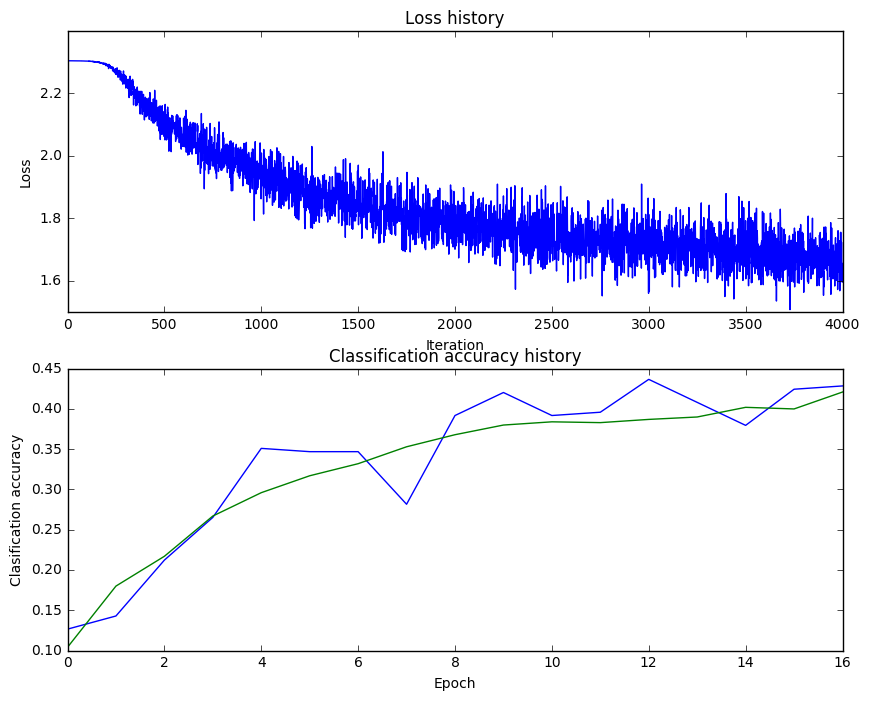

Called with 0.0001, 0.95, 0.5, 4000, 400
iteration 0 / 4000: loss 2.303378
iteration 100 / 4000: loss 2.302298
iteration 200 / 4000: loss 2.295686
iteration 300 / 4000: loss 2.278471
iteration 400 / 4000: loss 2.178030
iteration 500 / 4000: loss 2.033423
iteration 600 / 4000: loss 2.109031
iteration 700 / 4000: loss 2.001038
iteration 800 / 4000: loss 2.050852
iteration 900 / 4000: loss 2.004229
iteration 1000 / 4000: loss 2.029872
iteration 1100 / 4000: loss 1.987641
iteration 1200 / 4000: loss 1.956230
iteration 1300 / 4000: loss 1.860607
iteration 1400 / 4000: loss 1.979899
iteration 1500 / 4000: loss 1.968990
iteration 1600 / 4000: loss 1.822841
iteration 1700 / 4000: loss 1.861935
iteration 1800 / 4000: loss 1.967578
iteration 1900 / 4000: loss 1.844054
iteration 2000 / 4000: loss 1.659482
iteration 2100 / 4000: loss 1.732921
iteration 2200 / 4000: loss 1.876628
iteration 2300 / 4000: loss 2.023053
iteration 2400 / 4000: loss 1.738625
iteration 2500 / 4000: loss 1.773830
iteration

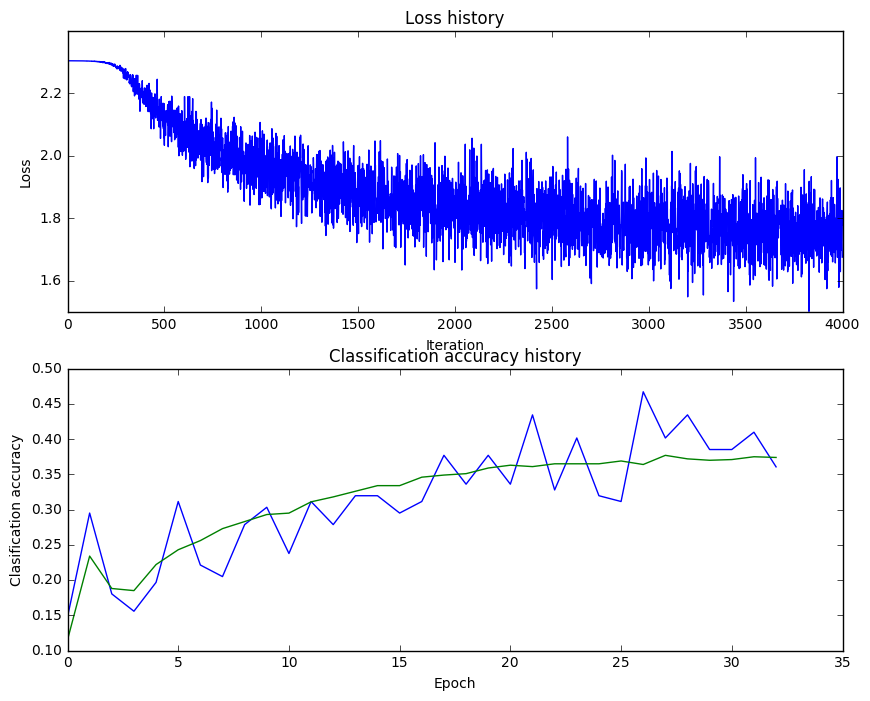

Called with 0.0001, 0.95, 0.5, 4000, 1000
iteration 0 / 4000: loss 2.303380
iteration 100 / 4000: loss 2.302344
iteration 200 / 4000: loss 2.297258
iteration 300 / 4000: loss 2.303362
iteration 400 / 4000: loss 2.214103
iteration 500 / 4000: loss 2.089516
iteration 600 / 4000: loss 2.097965
iteration 700 / 4000: loss 2.138283
iteration 800 / 4000: loss 1.954025
iteration 900 / 4000: loss 1.935577
iteration 1000 / 4000: loss 1.980277
iteration 1100 / 4000: loss 2.034641
iteration 1200 / 4000: loss 2.040592
iteration 1300 / 4000: loss 1.984279
iteration 1400 / 4000: loss 1.943637
iteration 1500 / 4000: loss 1.948726
iteration 1600 / 4000: loss 1.965758
iteration 1700 / 4000: loss 1.976457
iteration 1800 / 4000: loss 1.817036
iteration 1900 / 4000: loss 1.954275
iteration 2000 / 4000: loss 2.030518
iteration 2100 / 4000: loss 2.092439
iteration 2200 / 4000: loss 1.928375
iteration 2300 / 4000: loss 1.979111
iteration 2400 / 4000: loss 1.876380
iteration 2500 / 4000: loss 1.981057
iteratio

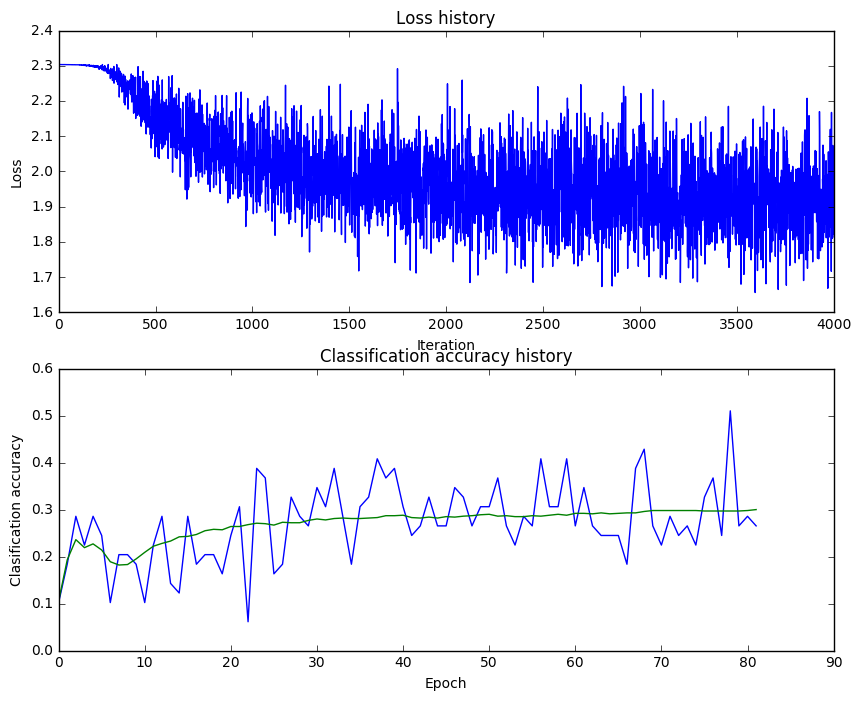

Called with 0.0001, 0.95, 0.5, 10000, 100
iteration 0 / 10000: loss 2.303327
iteration 100 / 10000: loss 2.302435
iteration 200 / 10000: loss 2.292828
iteration 300 / 10000: loss 2.235755
iteration 400 / 10000: loss 2.133708
iteration 500 / 10000: loss 2.089590
iteration 600 / 10000: loss 2.074871
iteration 700 / 10000: loss 2.022022
iteration 800 / 10000: loss 1.984898
iteration 900 / 10000: loss 2.000378
iteration 1000 / 10000: loss 1.842358
iteration 1100 / 10000: loss 1.921375
iteration 1200 / 10000: loss 1.872101
iteration 1300 / 10000: loss 1.839230
iteration 1400 / 10000: loss 1.881883
iteration 1500 / 10000: loss 1.837154
iteration 1600 / 10000: loss 1.771382
iteration 1700 / 10000: loss 1.745663
iteration 1800 / 10000: loss 1.769750
iteration 1900 / 10000: loss 1.761083
iteration 2000 / 10000: loss 1.748659
iteration 2100 / 10000: loss 1.760687
iteration 2200 / 10000: loss 1.764792
iteration 2300 / 10000: loss 1.777484
iteration 2400 / 10000: loss 1.770213
iteration 2500 / 100

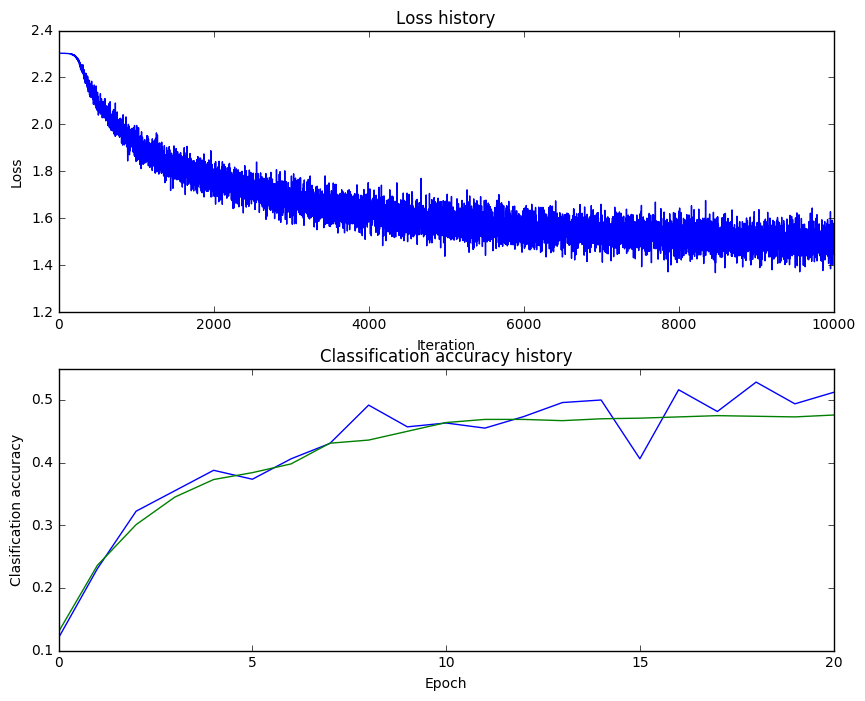

Called with 0.0001, 0.95, 0.5, 10000, 200
iteration 0 / 10000: loss 2.303353
iteration 100 / 10000: loss 2.302276
iteration 200 / 10000: loss 2.292203
iteration 300 / 10000: loss 2.249166
iteration 400 / 10000: loss 2.158443
iteration 500 / 10000: loss 2.108007
iteration 600 / 10000: loss 1.977124
iteration 700 / 10000: loss 2.022633
iteration 800 / 10000: loss 1.988953
iteration 900 / 10000: loss 1.974137
iteration 1000 / 10000: loss 1.894106
iteration 1100 / 10000: loss 1.840348
iteration 1200 / 10000: loss 1.947624
iteration 1300 / 10000: loss 1.920457
iteration 1400 / 10000: loss 1.853614
iteration 1500 / 10000: loss 1.888168
iteration 1600 / 10000: loss 1.873089
iteration 1700 / 10000: loss 1.772713
iteration 1800 / 10000: loss 1.912268
iteration 1900 / 10000: loss 1.784192
iteration 2000 / 10000: loss 1.877625
iteration 2100 / 10000: loss 1.752745
iteration 2200 / 10000: loss 1.875220
iteration 2300 / 10000: loss 1.758500
iteration 2400 / 10000: loss 1.682869
iteration 2500 / 100

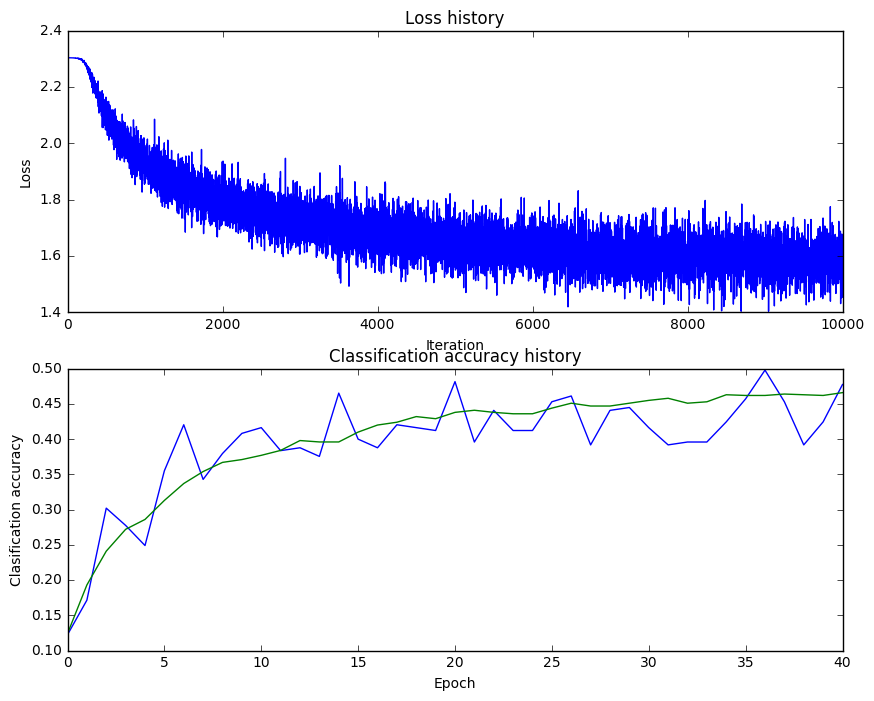

Called with 0.0001, 0.95, 0.5, 10000, 400
iteration 0 / 10000: loss 2.303347
iteration 100 / 10000: loss 2.302502
iteration 200 / 10000: loss 2.296461
iteration 300 / 10000: loss 2.241982
iteration 400 / 10000: loss 2.198484
iteration 500 / 10000: loss 2.166430
iteration 600 / 10000: loss 2.088327
iteration 700 / 10000: loss 1.996867
iteration 800 / 10000: loss 1.977742
iteration 900 / 10000: loss 1.993722
iteration 1000 / 10000: loss 1.924948
iteration 1100 / 10000: loss 1.961944
iteration 1200 / 10000: loss 1.885706
iteration 1300 / 10000: loss 1.828255
iteration 1400 / 10000: loss 1.875375
iteration 1500 / 10000: loss 1.875791
iteration 1600 / 10000: loss 1.892144
iteration 1700 / 10000: loss 1.785933
iteration 1800 / 10000: loss 1.901931
iteration 1900 / 10000: loss 1.811990
iteration 2000 / 10000: loss 1.836266
iteration 2100 / 10000: loss 1.987951
iteration 2200 / 10000: loss 1.826150
iteration 2300 / 10000: loss 1.849528
iteration 2400 / 10000: loss 1.819059
iteration 2500 / 100

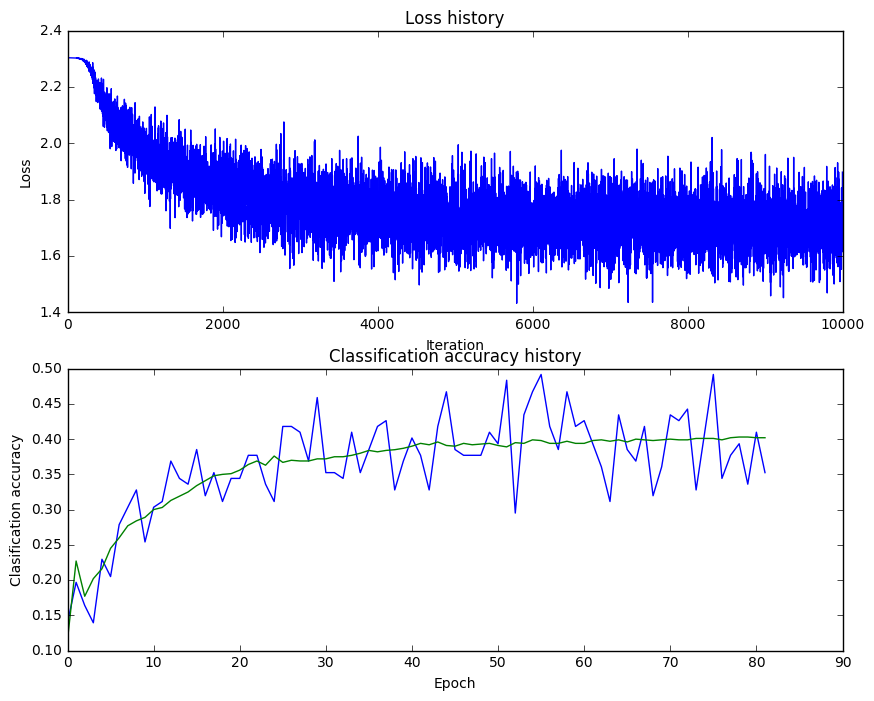

Called with 0.0001, 0.95, 0.5, 10000, 1000
iteration 0 / 10000: loss 2.303355
iteration 100 / 10000: loss 2.302443
iteration 200 / 10000: loss 2.296372
iteration 300 / 10000: loss 2.253892
iteration 400 / 10000: loss 2.165358
iteration 500 / 10000: loss 2.160256
iteration 600 / 10000: loss 2.154610
iteration 700 / 10000: loss 2.075971
iteration 800 / 10000: loss 2.038555
iteration 900 / 10000: loss 2.122311
iteration 1000 / 10000: loss 2.023345
iteration 1100 / 10000: loss 2.043886
iteration 1200 / 10000: loss 1.959908
iteration 1300 / 10000: loss 2.040078
iteration 1400 / 10000: loss 2.183823
iteration 1500 / 10000: loss 1.751459
iteration 1600 / 10000: loss 1.914782
iteration 1700 / 10000: loss 1.895987
iteration 1800 / 10000: loss 1.942393
iteration 1900 / 10000: loss 2.004800
iteration 2000 / 10000: loss 1.986076
iteration 2100 / 10000: loss 2.089193
iteration 2200 / 10000: loss 1.934733
iteration 2300 / 10000: loss 2.034870
iteration 2400 / 10000: loss 1.969560
iteration 2500 / 10

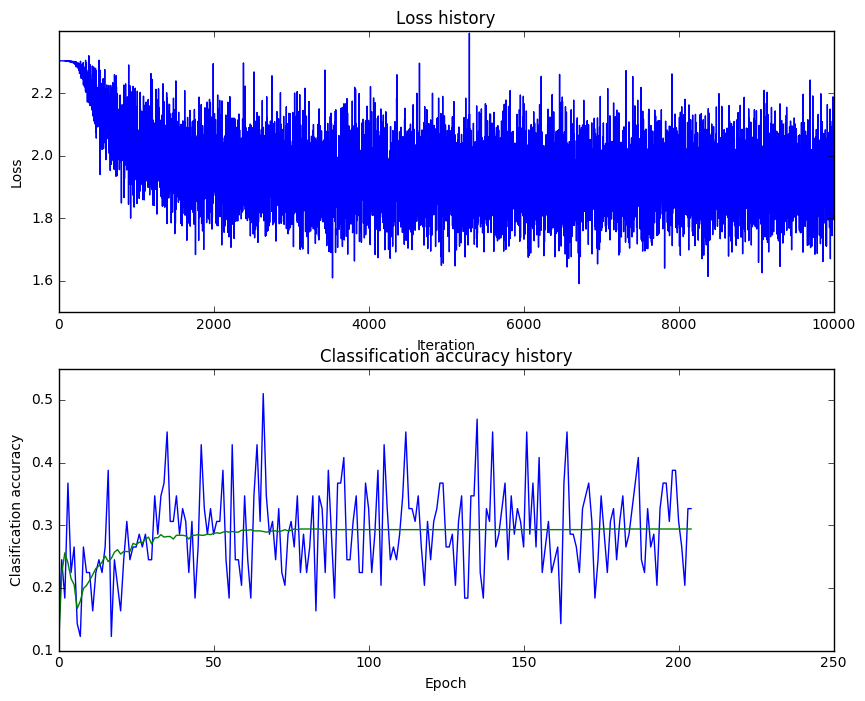

hidden layer size 1000
Called with 0.0001, 0.95, 0.5, 1000, 100
iteration 0 / 1000: loss 2.310255
iteration 100 / 1000: loss 2.301394
iteration 200 / 1000: loss 2.244316
iteration 300 / 1000: loss 2.154927
iteration 400 / 1000: loss 2.129769
iteration 500 / 1000: loss 1.966902
iteration 600 / 1000: loss 2.022047
iteration 700 / 1000: loss 1.942235
iteration 800 / 1000: loss 1.887128
iteration 900 / 1000: loss 1.858200
Validation accuracy:  0.331


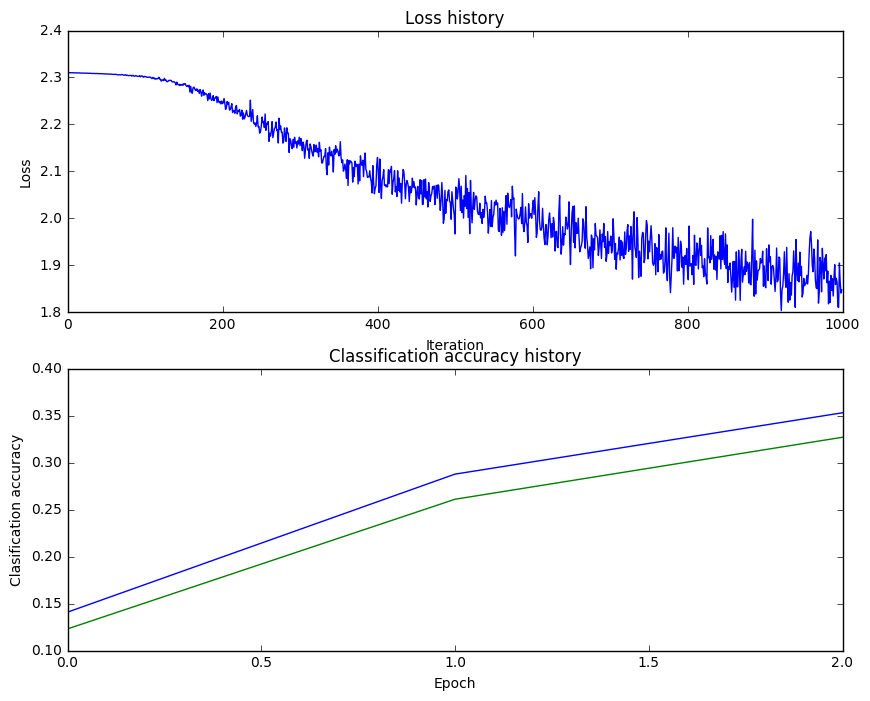

Called with 0.0001, 0.95, 0.5, 1000, 200
iteration 0 / 1000: loss 2.310291
iteration 100 / 1000: loss 2.302105
iteration 200 / 1000: loss 2.251237
iteration 300 / 1000: loss 2.135900
iteration 400 / 1000: loss 2.076372
iteration 500 / 1000: loss 2.069180
iteration 600 / 1000: loss 1.984256
iteration 700 / 1000: loss 1.909984
iteration 800 / 1000: loss 1.964949
iteration 900 / 1000: loss 1.847375
Validation accuracy:  0.326


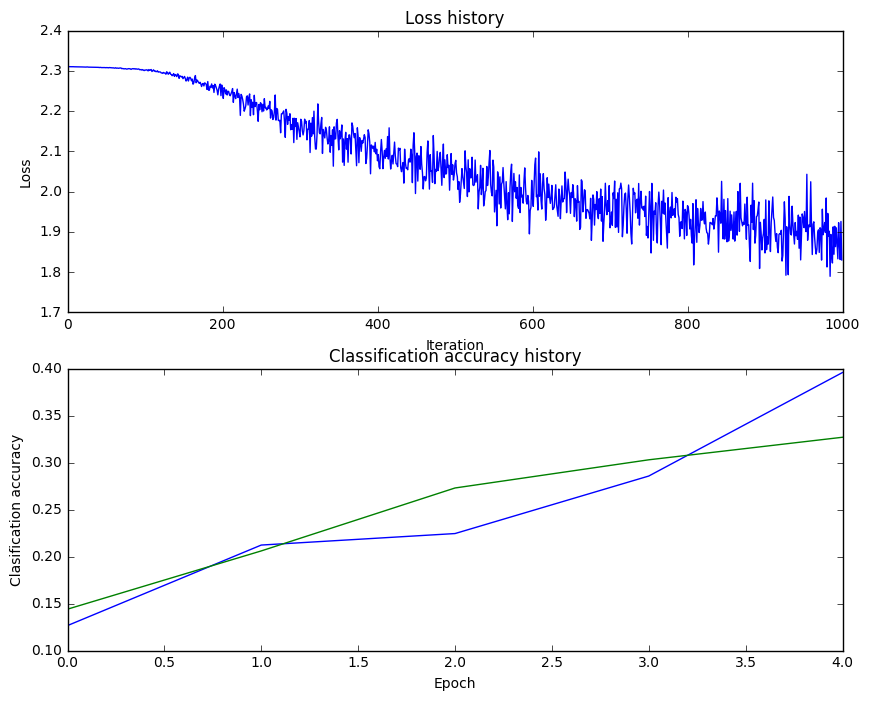

Called with 0.0001, 0.95, 0.5, 1000, 400
iteration 0 / 1000: loss 2.310276
iteration 100 / 1000: loss 2.300395
iteration 200 / 1000: loss 2.247957
iteration 300 / 1000: loss 2.157654
iteration 400 / 1000: loss 2.098995
iteration 500 / 1000: loss 2.100183
iteration 600 / 1000: loss 1.948753
iteration 700 / 1000: loss 1.973651
iteration 800 / 1000: loss 1.995346
iteration 900 / 1000: loss 1.943916
Validation accuracy:  0.314


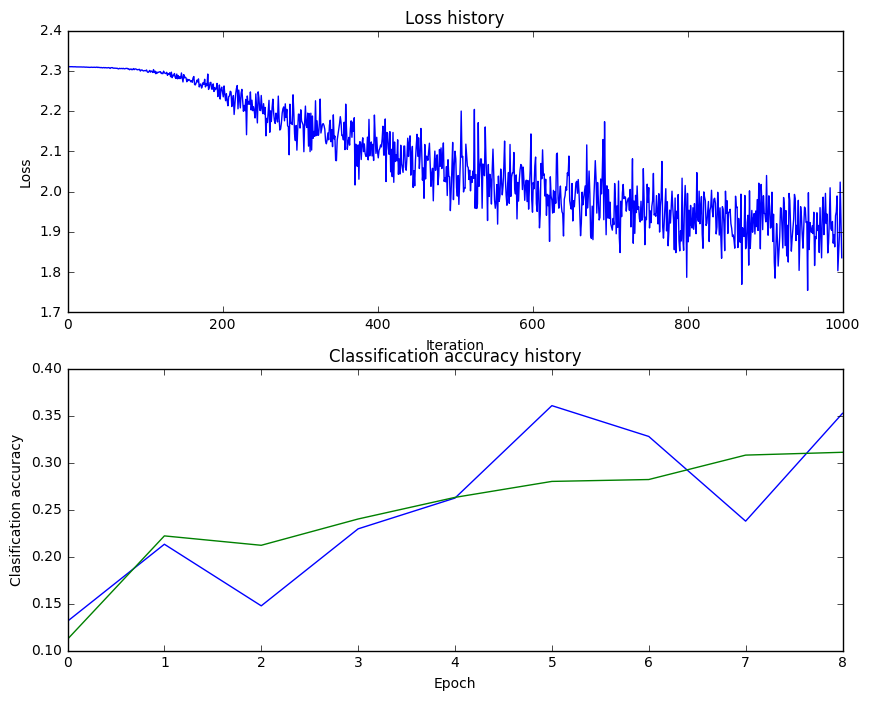

Called with 0.0001, 0.95, 0.5, 1000, 1000
iteration 0 / 1000: loss 2.310207
iteration 100 / 1000: loss 2.298613
iteration 200 / 1000: loss 2.270364
iteration 300 / 1000: loss 2.207618
iteration 400 / 1000: loss 2.142831
iteration 500 / 1000: loss 2.030784
iteration 600 / 1000: loss 1.909749
iteration 700 / 1000: loss 1.934624
iteration 800 / 1000: loss 1.880608
iteration 900 / 1000: loss 1.821317
Validation accuracy:  0.286


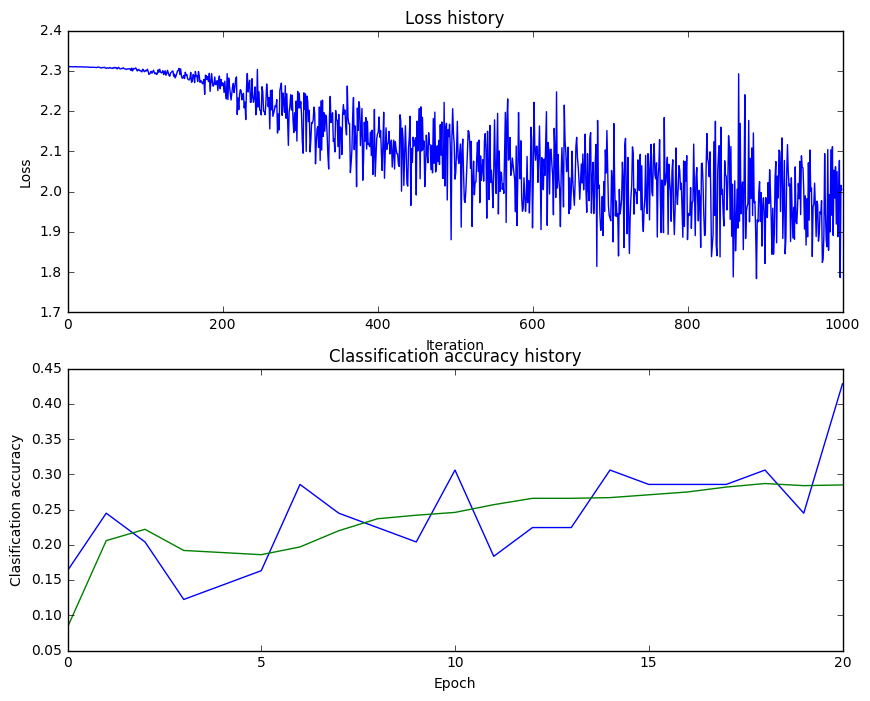

Called with 0.0001, 0.95, 0.5, 2000, 100
iteration 0 / 2000: loss 2.310247
iteration 100 / 2000: loss 2.301392
iteration 200 / 2000: loss 2.239072
iteration 300 / 2000: loss 2.174467
iteration 400 / 2000: loss 2.087986
iteration 500 / 2000: loss 2.050920
iteration 600 / 2000: loss 1.985543
iteration 700 / 2000: loss 1.929564
iteration 800 / 2000: loss 1.887358
iteration 900 / 2000: loss 1.892045
iteration 1000 / 2000: loss 1.910697
iteration 1100 / 2000: loss 1.833182
iteration 1200 / 2000: loss 1.887636
iteration 1300 / 2000: loss 1.843192
iteration 1400 / 2000: loss 1.819877
iteration 1500 / 2000: loss 1.765187
iteration 1600 / 2000: loss 1.767383
iteration 1700 / 2000: loss 1.744508
iteration 1800 / 2000: loss 1.793483
iteration 1900 / 2000: loss 1.743189
Validation accuracy:  0.389


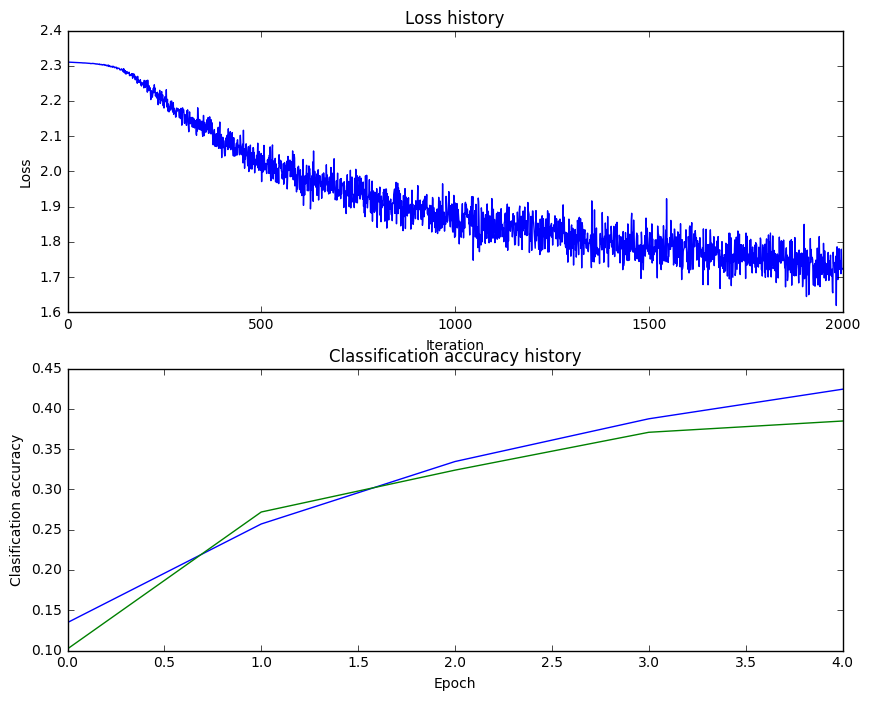

Called with 0.0001, 0.95, 0.5, 2000, 200
iteration 0 / 2000: loss 2.310357
iteration 100 / 2000: loss 2.299196
iteration 200 / 2000: loss 2.247202
iteration 300 / 2000: loss 2.189045
iteration 400 / 2000: loss 2.098935
iteration 500 / 2000: loss 2.040240
iteration 600 / 2000: loss 1.947712
iteration 700 / 2000: loss 1.997235
iteration 800 / 2000: loss 1.945933
iteration 900 / 2000: loss 1.912582
iteration 1000 / 2000: loss 1.831022
iteration 1100 / 2000: loss 1.894425
iteration 1200 / 2000: loss 1.840416
iteration 1300 / 2000: loss 1.705405
iteration 1400 / 2000: loss 1.894542
iteration 1500 / 2000: loss 1.841921
iteration 1600 / 2000: loss 1.827230
iteration 1700 / 2000: loss 1.908096
iteration 1800 / 2000: loss 1.679036
iteration 1900 / 2000: loss 1.676870
Validation accuracy:  0.378


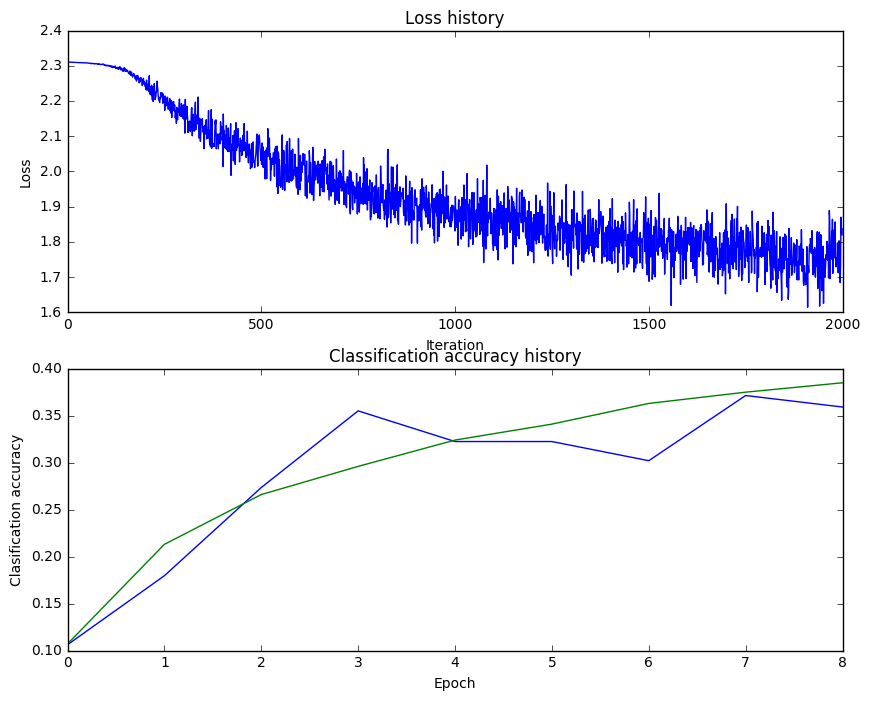

Called with 0.0001, 0.95, 0.5, 2000, 400
iteration 0 / 2000: loss 2.310301
iteration 100 / 2000: loss 2.299796
iteration 200 / 2000: loss 2.242830
iteration 300 / 2000: loss 2.174918
iteration 400 / 2000: loss 2.059293
iteration 500 / 2000: loss 2.090128
iteration 600 / 2000: loss 1.974072
iteration 700 / 2000: loss 2.016646
iteration 800 / 2000: loss 1.996894
iteration 900 / 2000: loss 1.955806
iteration 1000 / 2000: loss 1.904199
iteration 1100 / 2000: loss 1.887806
iteration 1200 / 2000: loss 1.902483
iteration 1300 / 2000: loss 1.881747
iteration 1400 / 2000: loss 1.772258
iteration 1500 / 2000: loss 1.912177
iteration 1600 / 2000: loss 1.787110
iteration 1700 / 2000: loss 2.001617
iteration 1800 / 2000: loss 1.720083
iteration 1900 / 2000: loss 1.737267
Validation accuracy:  0.369


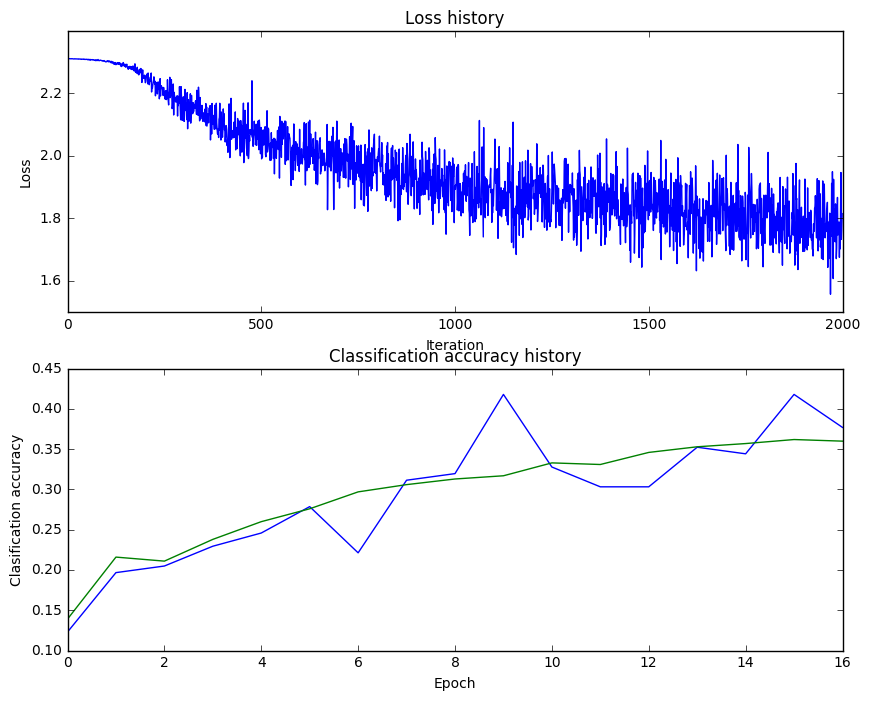

Called with 0.0001, 0.95, 0.5, 2000, 1000
iteration 0 / 2000: loss 2.310310
iteration 100 / 2000: loss 2.299445
iteration 200 / 2000: loss 2.234775
iteration 300 / 2000: loss 2.136595
iteration 400 / 2000: loss 2.212820
iteration 500 / 2000: loss 2.034961
iteration 600 / 2000: loss 2.028920
iteration 700 / 2000: loss 2.038645
iteration 800 / 2000: loss 2.033606
iteration 900 / 2000: loss 2.050519
iteration 1000 / 2000: loss 1.796140
iteration 1100 / 2000: loss 1.868410
iteration 1200 / 2000: loss 1.975833
iteration 1300 / 2000: loss 2.031804
iteration 1400 / 2000: loss 1.926884
iteration 1500 / 2000: loss 1.971411
iteration 1600 / 2000: loss 1.855679
iteration 1700 / 2000: loss 1.975637
iteration 1800 / 2000: loss 1.827921
iteration 1900 / 2000: loss 2.044140
Validation accuracy:  0.318


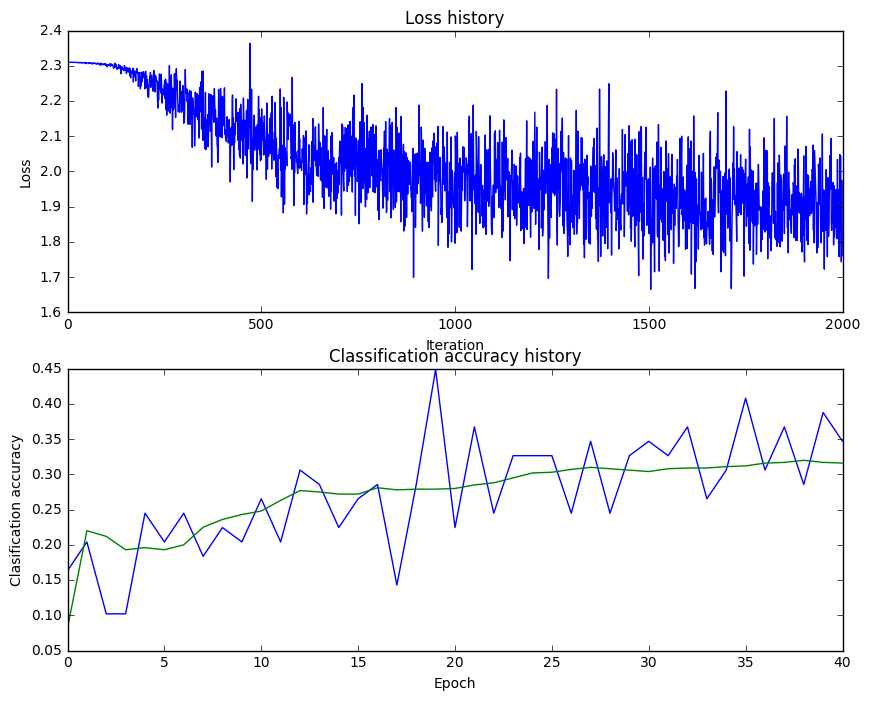

Called with 0.0001, 0.95, 0.5, 4000, 100
iteration 0 / 4000: loss 2.310208
iteration 100 / 4000: loss 2.300796
iteration 200 / 4000: loss 2.244875
iteration 300 / 4000: loss 2.143622
iteration 400 / 4000: loss 2.062895
iteration 500 / 4000: loss 1.977784
iteration 600 / 4000: loss 2.052289
iteration 700 / 4000: loss 1.950958
iteration 800 / 4000: loss 1.888562
iteration 900 / 4000: loss 1.867864
iteration 1000 / 4000: loss 1.821339
iteration 1100 / 4000: loss 1.844936
iteration 1200 / 4000: loss 1.847141
iteration 1300 / 4000: loss 1.792720
iteration 1400 / 4000: loss 1.773249
iteration 1500 / 4000: loss 1.718735
iteration 1600 / 4000: loss 1.727061
iteration 1700 / 4000: loss 1.721982
iteration 1800 / 4000: loss 1.767686
iteration 1900 / 4000: loss 1.725027
iteration 2000 / 4000: loss 1.705583
iteration 2100 / 4000: loss 1.771961
iteration 2200 / 4000: loss 1.686912
iteration 2300 / 4000: loss 1.671184
iteration 2400 / 4000: loss 1.652394
iteration 2500 / 4000: loss 1.720900
iteration

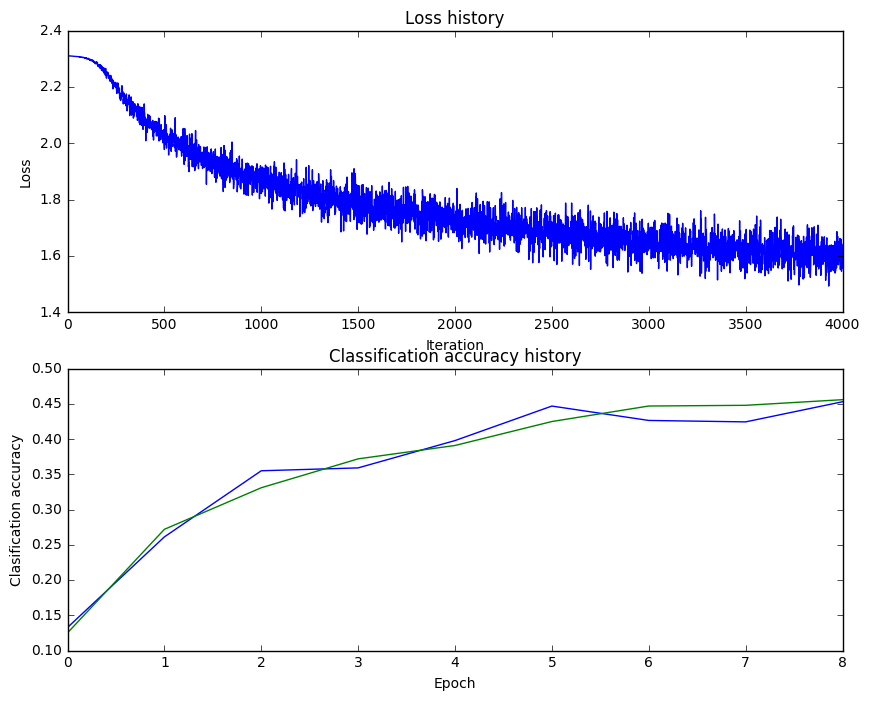

Called with 0.0001, 0.95, 0.5, 4000, 200
iteration 0 / 4000: loss 2.310251
iteration 100 / 4000: loss 2.300913
iteration 200 / 4000: loss 2.251647
iteration 300 / 4000: loss 2.135501
iteration 400 / 4000: loss 2.069809
iteration 500 / 4000: loss 2.100963
iteration 600 / 4000: loss 1.999476
iteration 700 / 4000: loss 1.974837
iteration 800 / 4000: loss 1.834203
iteration 900 / 4000: loss 1.931099
iteration 1000 / 4000: loss 1.834713
iteration 1100 / 4000: loss 1.841336
iteration 1200 / 4000: loss 1.880964
iteration 1300 / 4000: loss 1.953737
iteration 1400 / 4000: loss 1.875728
iteration 1500 / 4000: loss 1.898661
iteration 1600 / 4000: loss 1.729692
iteration 1700 / 4000: loss 1.821727
iteration 1800 / 4000: loss 1.799421
iteration 1900 / 4000: loss 1.716403
iteration 2000 / 4000: loss 1.712514
iteration 2100 / 4000: loss 1.714928
iteration 2200 / 4000: loss 1.810044
iteration 2300 / 4000: loss 1.697582
iteration 2400 / 4000: loss 1.729239
iteration 2500 / 4000: loss 1.685768
iteration

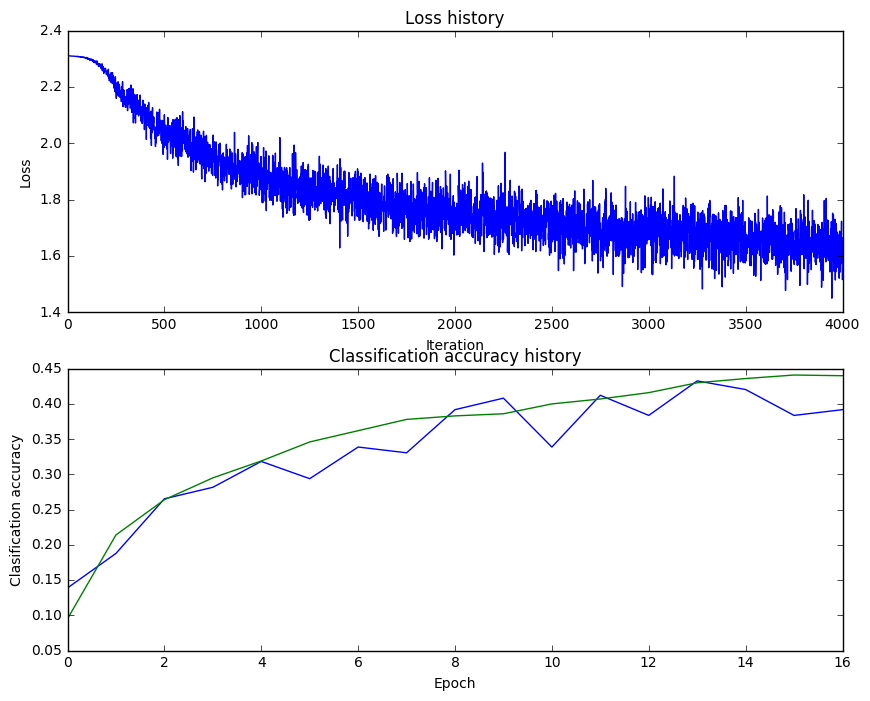

Called with 0.0001, 0.95, 0.5, 4000, 400
iteration 0 / 4000: loss 2.310289
iteration 100 / 4000: loss 2.301637
iteration 200 / 4000: loss 2.252785
iteration 300 / 4000: loss 2.171003
iteration 400 / 4000: loss 2.118703
iteration 500 / 4000: loss 1.985631
iteration 600 / 4000: loss 1.963573
iteration 700 / 4000: loss 1.944041
iteration 800 / 4000: loss 1.818196
iteration 900 / 4000: loss 1.773551
iteration 1000 / 4000: loss 1.885026
iteration 1100 / 4000: loss 1.847882
iteration 1200 / 4000: loss 1.856631
iteration 1300 / 4000: loss 1.944563
iteration 1400 / 4000: loss 1.863472
iteration 1500 / 4000: loss 1.853756
iteration 1600 / 4000: loss 1.863376
iteration 1700 / 4000: loss 1.886200
iteration 1800 / 4000: loss 1.835910
iteration 1900 / 4000: loss 1.815561
iteration 2000 / 4000: loss 1.820298
iteration 2100 / 4000: loss 1.694749
iteration 2200 / 4000: loss 1.678120
iteration 2300 / 4000: loss 1.890082
iteration 2400 / 4000: loss 1.623906
iteration 2500 / 4000: loss 1.892715
iteration

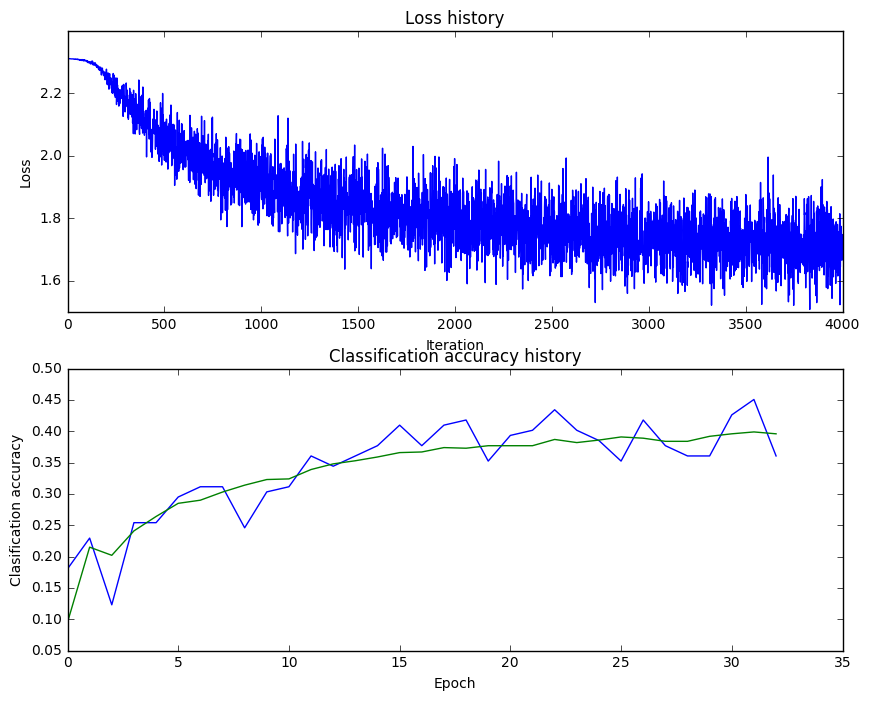

Called with 0.0001, 0.95, 0.5, 4000, 1000
iteration 0 / 4000: loss 2.310232
iteration 100 / 4000: loss 2.298080
iteration 200 / 4000: loss 2.243354
iteration 300 / 4000: loss 2.255290
iteration 400 / 4000: loss 2.197028
iteration 500 / 4000: loss 2.030044
iteration 600 / 4000: loss 1.985736
iteration 700 / 4000: loss 1.993185
iteration 800 / 4000: loss 2.019240
iteration 900 / 4000: loss 2.011439
iteration 1000 / 4000: loss 1.856871
iteration 1100 / 4000: loss 1.969511
iteration 1200 / 4000: loss 1.993626
iteration 1300 / 4000: loss 2.079175
iteration 1400 / 4000: loss 1.922491
iteration 1500 / 4000: loss 1.927219
iteration 1600 / 4000: loss 1.882428
iteration 1700 / 4000: loss 1.905025
iteration 1800 / 4000: loss 2.056876
iteration 1900 / 4000: loss 1.904943
iteration 2000 / 4000: loss 1.987699
iteration 2100 / 4000: loss 1.827591
iteration 2200 / 4000: loss 1.829400
iteration 2300 / 4000: loss 2.064709
iteration 2400 / 4000: loss 1.768989
iteration 2500 / 4000: loss 1.852326
iteratio

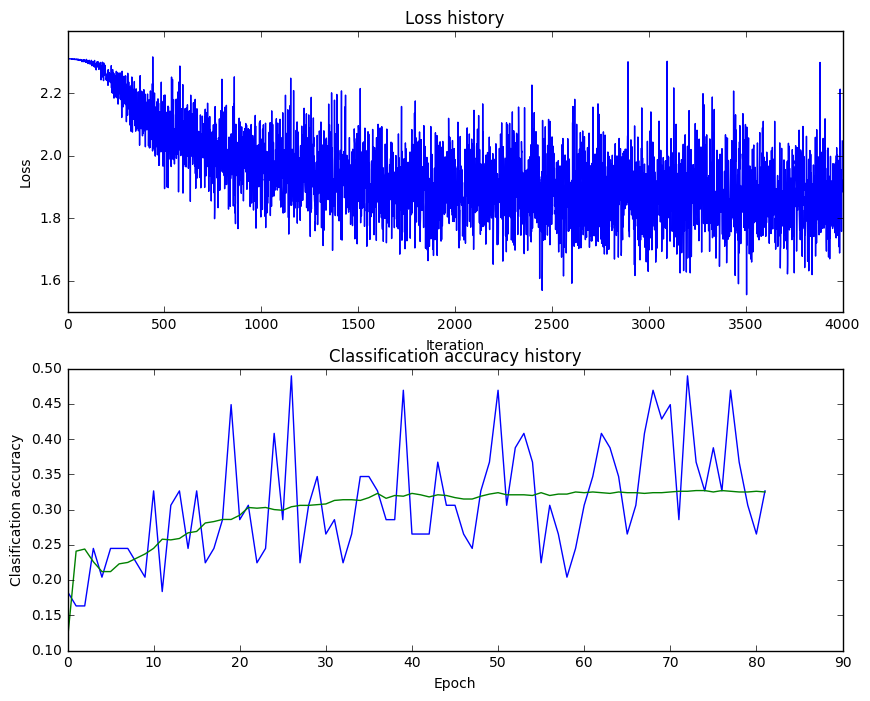

Called with 0.0001, 0.95, 0.5, 10000, 100
iteration 0 / 10000: loss 2.310308
iteration 100 / 10000: loss 2.302757
iteration 200 / 10000: loss 2.250884
iteration 300 / 10000: loss 2.161815
iteration 400 / 10000: loss 2.109403
iteration 500 / 10000: loss 2.026670
iteration 600 / 10000: loss 2.003996
iteration 700 / 10000: loss 1.938513
iteration 800 / 10000: loss 1.896311
iteration 900 / 10000: loss 1.851209
iteration 1000 / 10000: loss 1.883690
iteration 1100 / 10000: loss 1.815036
iteration 1200 / 10000: loss 1.823822
iteration 1300 / 10000: loss 1.766239
iteration 1400 / 10000: loss 1.768866
iteration 1500 / 10000: loss 1.781029
iteration 1600 / 10000: loss 1.756294
iteration 1700 / 10000: loss 1.770632
iteration 1800 / 10000: loss 1.742867
iteration 1900 / 10000: loss 1.741281
iteration 2000 / 10000: loss 1.653516
iteration 2100 / 10000: loss 1.709196
iteration 2200 / 10000: loss 1.693067
iteration 2300 / 10000: loss 1.669149
iteration 2400 / 10000: loss 1.727431
iteration 2500 / 100

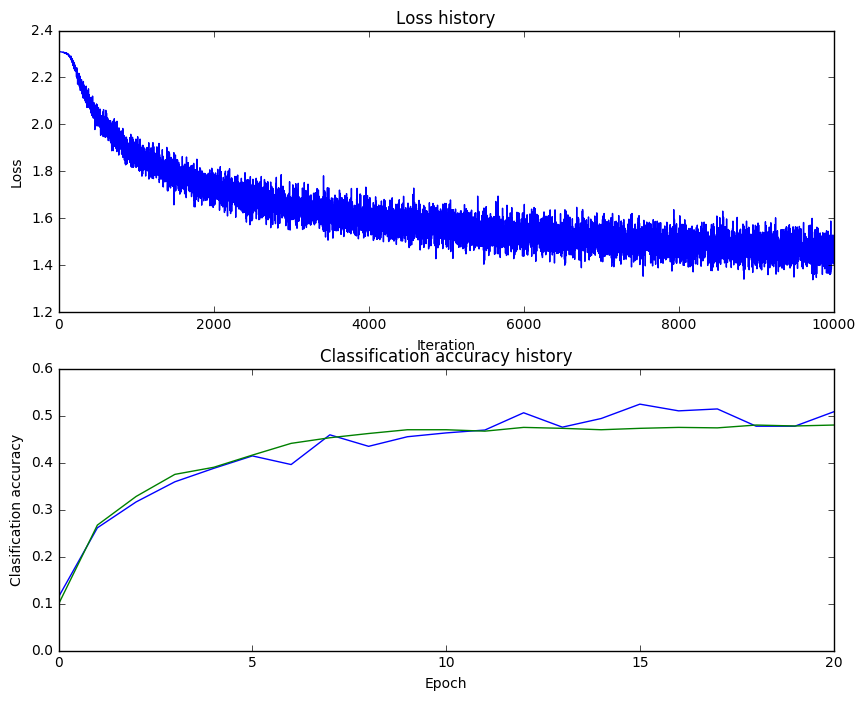

Called with 0.0001, 0.95, 0.5, 10000, 200
iteration 0 / 10000: loss 2.310296
iteration 100 / 10000: loss 2.303122
iteration 200 / 10000: loss 2.248826
iteration 300 / 10000: loss 2.174617
iteration 400 / 10000: loss 2.141336
iteration 500 / 10000: loss 2.057415
iteration 600 / 10000: loss 1.998801
iteration 700 / 10000: loss 1.998557
iteration 800 / 10000: loss 1.922538
iteration 900 / 10000: loss 1.997034
iteration 1000 / 10000: loss 1.849304
iteration 1100 / 10000: loss 1.796924
iteration 1200 / 10000: loss 1.896229
iteration 1300 / 10000: loss 1.861844
iteration 1400 / 10000: loss 1.755931
iteration 1500 / 10000: loss 1.806862
iteration 1600 / 10000: loss 1.759950
iteration 1700 / 10000: loss 1.952457
iteration 1800 / 10000: loss 1.780431
iteration 1900 / 10000: loss 1.739307
iteration 2000 / 10000: loss 1.820617
iteration 2100 / 10000: loss 1.739917
iteration 2200 / 10000: loss 1.710543
iteration 2300 / 10000: loss 1.804846
iteration 2400 / 10000: loss 1.680005
iteration 2500 / 100

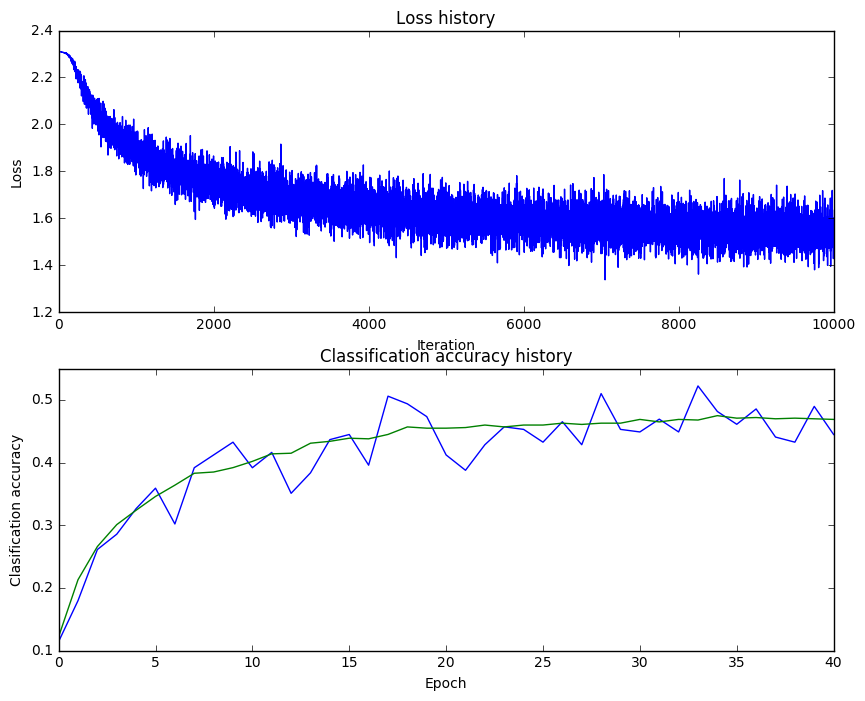

Called with 0.0001, 0.95, 0.5, 10000, 400
iteration 0 / 10000: loss 2.310198
iteration 100 / 10000: loss 2.303306
iteration 200 / 10000: loss 2.218894
iteration 300 / 10000: loss 2.175677
iteration 400 / 10000: loss 2.116487
iteration 500 / 10000: loss 2.042665
iteration 600 / 10000: loss 1.984962
iteration 700 / 10000: loss 1.951033
iteration 800 / 10000: loss 1.880063
iteration 900 / 10000: loss 1.997181
iteration 1000 / 10000: loss 1.833007
iteration 1100 / 10000: loss 1.827961
iteration 1200 / 10000: loss 1.907424
iteration 1300 / 10000: loss 1.886161
iteration 1400 / 10000: loss 1.900766
iteration 1500 / 10000: loss 1.777948
iteration 1600 / 10000: loss 1.858787
iteration 1700 / 10000: loss 1.839708
iteration 1800 / 10000: loss 1.793228
iteration 1900 / 10000: loss 1.701633
iteration 2000 / 10000: loss 1.795350
iteration 2100 / 10000: loss 1.824084
iteration 2200 / 10000: loss 1.786498
iteration 2300 / 10000: loss 1.802196
iteration 2400 / 10000: loss 1.727897
iteration 2500 / 100

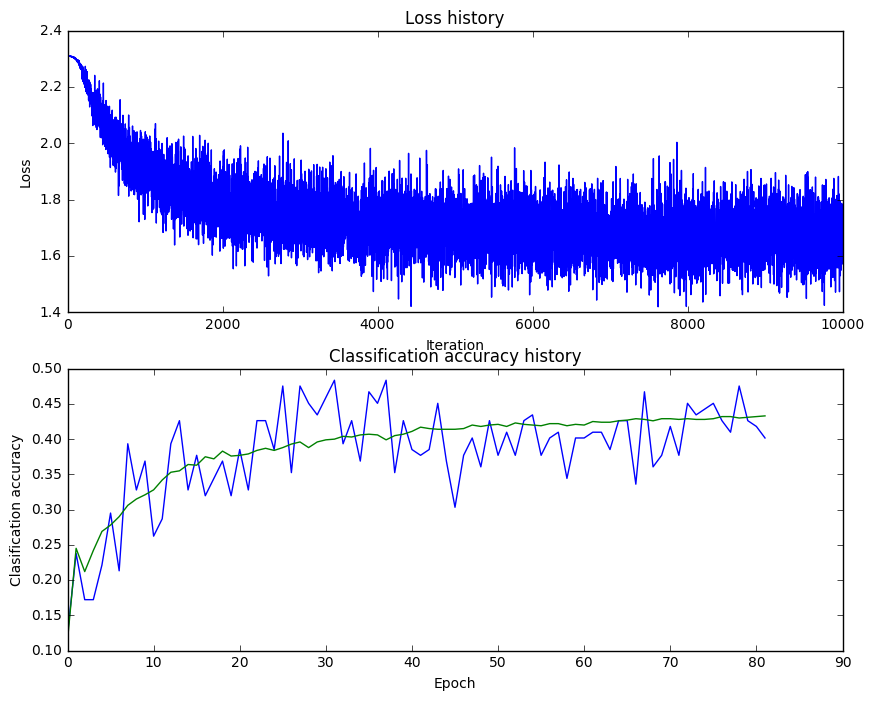

Called with 0.0001, 0.95, 0.5, 10000, 1000
iteration 0 / 10000: loss 2.310238
iteration 100 / 10000: loss 2.295606
iteration 200 / 10000: loss 2.278618
iteration 300 / 10000: loss 2.175900
iteration 400 / 10000: loss 2.037028
iteration 500 / 10000: loss 2.115945
iteration 600 / 10000: loss 1.936326
iteration 700 / 10000: loss 2.056631
iteration 800 / 10000: loss 2.112901
iteration 900 / 10000: loss 1.954739
iteration 1000 / 10000: loss 2.028008
iteration 1100 / 10000: loss 1.934397
iteration 1200 / 10000: loss 1.988952
iteration 1300 / 10000: loss 1.851810
iteration 1400 / 10000: loss 1.944066
iteration 1500 / 10000: loss 2.072795
iteration 1600 / 10000: loss 2.013027
iteration 1700 / 10000: loss 2.003379
iteration 1800 / 10000: loss 2.023166
iteration 1900 / 10000: loss 1.898105
iteration 2000 / 10000: loss 1.839952
iteration 2100 / 10000: loss 1.799328
iteration 2200 / 10000: loss 1.984198
iteration 2300 / 10000: loss 1.817841
iteration 2400 / 10000: loss 1.893899
iteration 2500 / 10

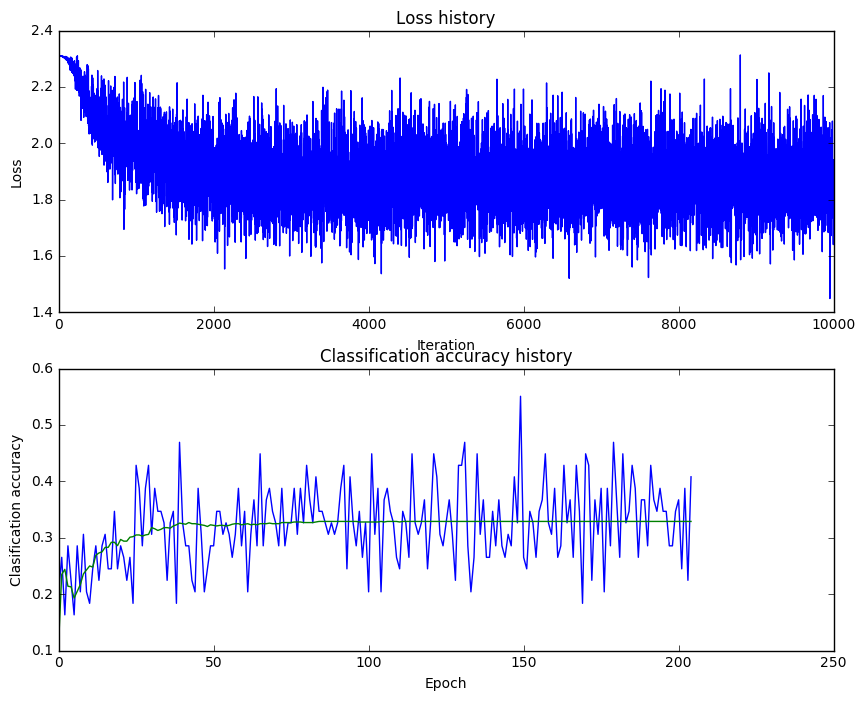

In [73]:
def find_best_net():
    best_net = None # store the best model into this 

    #################################################################################
    # TODO: Tune hyperparameters using the validation set. Store your best trained  #
    # model in best_net.                                                            #
    #                                                                               #
    # To help debug your network, it may help to use visualizations similar to the  #
    # ones we used above; these visualizations will have significant qualitative    #
    # differences from the ones we saw above for the poorly tuned network.          #
    #                                                                               #
    # Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
    # write code to sweep through possible combinations of hyperparameters          #
    # automatically like we did on the previous exercises.                          #
    #################################################################################

    input_size = 32 * 32 * 3
    hidden_size = 100
    num_classes = 10
    learning_rate = 1e-4
    accuracies = []
    for hidden_size in [10, 100, 1000]:
        print "hidden layer size {}".format(hidden_size)
        for num_iters in [1000,2000,4000,10000]:
            for batch_size in [100,200,400,1000]:
                net = TwoLayerNet(input_size, hidden_size, num_classes)
                    # Train the network
                stats = net.train(X_train, y_train, X_val, y_val,
                            num_iters=num_iters, batch_size=batch_size,
                            learning_rate=learning_rate, learning_rate_decay=0.95,
                            reg=0.5, verbose=True)

                # Predict on the validation set
                val_acc = (net.predict(X_val) == y_val).mean()
                print 'Validation accuracy: ', val_acc
                accuracies << {'accuracy': val_acc,
                              'hidden_size': hidden_size,
                              'batch_size': batch_size,
                              'num_ters': num_iters
                             }
                # plot our results
                plot_loss_accuracy()
    print accuracies
    
# this takes a few hours to run on my laptop. the best results are hight iterations, low batch size
# the hidden network size is better at 100, almost the same at 1000, worse at 10. 
# find_best_net() 



Called with 0.001, 0.95, 0.5, 100000, 50
iteration 0 / 100000: loss 2.303642
iteration 100 / 100000: loss 1.882269
iteration 200 / 100000: loss 1.739441
iteration 300 / 100000: loss 1.697710
iteration 400 / 100000: loss 1.633530
iteration 500 / 100000: loss 1.585051
iteration 600 / 100000: loss 1.543164
iteration 700 / 100000: loss 1.497459
iteration 800 / 100000: loss 1.462483
iteration 900 / 100000: loss 1.419911
iteration 1000 / 100000: loss 1.451263
iteration 1100 / 100000: loss 1.458199
iteration 1200 / 100000: loss 1.403544
iteration 1300 / 100000: loss 1.345752
iteration 1400 / 100000: loss 1.402917
iteration 1500 / 100000: loss 1.380046
iteration 1600 / 100000: loss 1.347769
iteration 1700 / 100000: loss 1.457128
iteration 1800 / 100000: loss 1.356345
iteration 1900 / 100000: loss 1.355397
iteration 2000 / 100000: loss 1.314158
iteration 2100 / 100000: loss 1.386041
iteration 2200 / 100000: loss 1.304631
iteration 2300 / 100000: loss 1.386878
iteration 2400 / 100000: loss 1.292

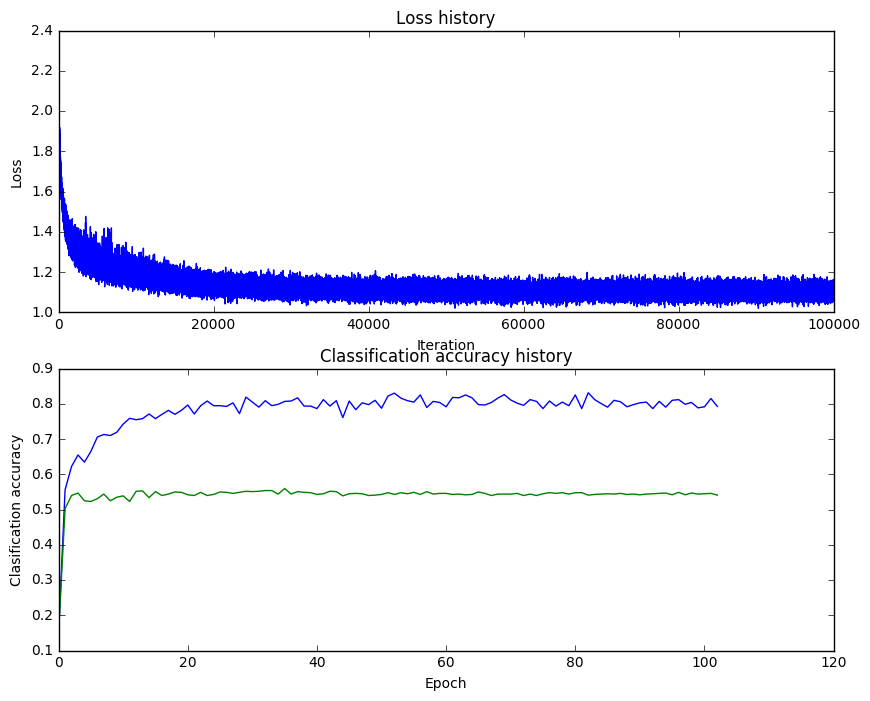

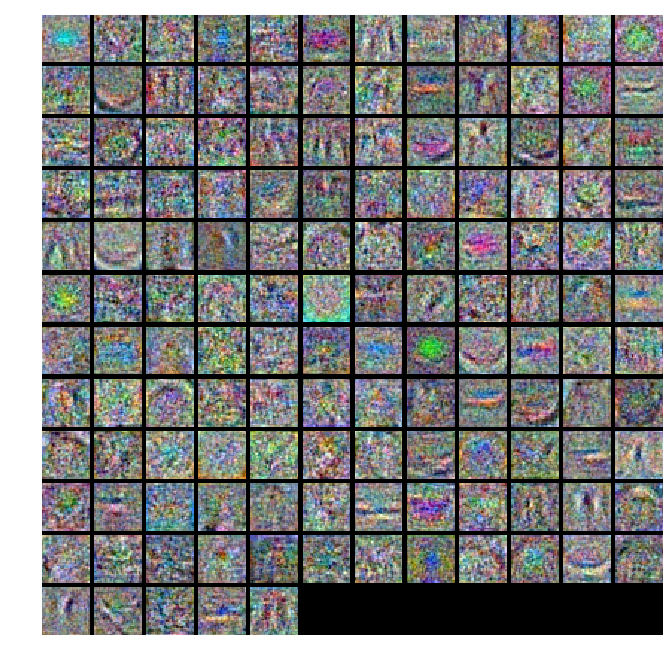

In [14]:
num_iters = 100000
hidden_size = 137
batch_size = 50
learning_rate = 1e-3
input_size = 32 * 32 * 3
num_classes = 10
    
best_net = TwoLayerNet(input_size, hidden_size, num_classes)
    # Train the network
stats = best_net.train(X_train, y_train, X_val, y_val,
            num_iters=num_iters, batch_size=batch_size,
            learning_rate=learning_rate, learning_rate_decay=0.95,
            reg=0.5, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print 'Validation accuracy: ', val_acc
# plot our results`
plot_loss_accuracy()
# visualize the weights of the best network
show_net_weights(best_net)

# Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 48%.

**We will give you extra bonus point for every 1% of accuracy above 52%.**

Validation accuracy:  0.543


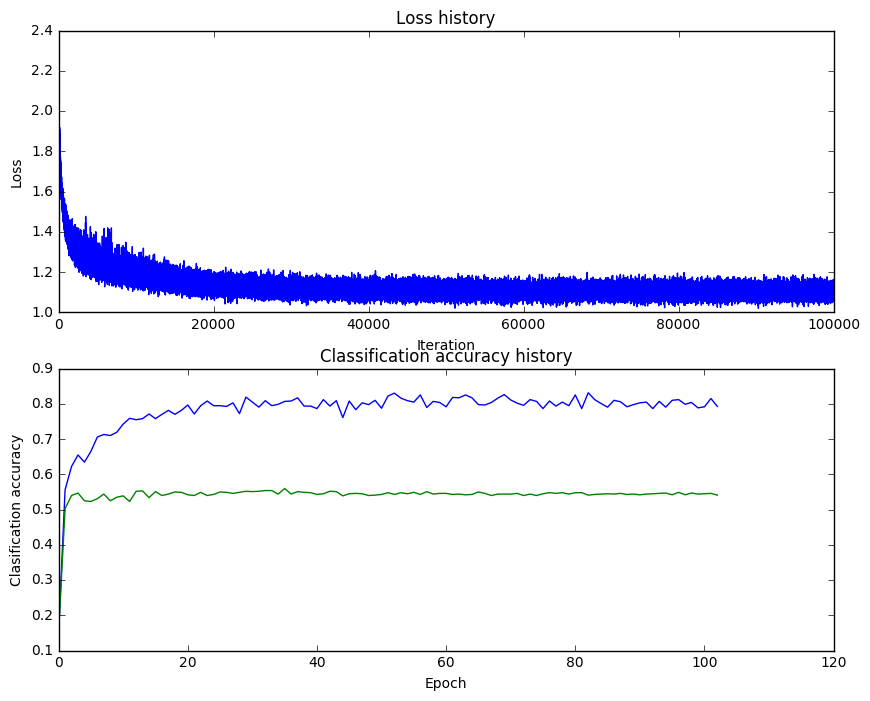

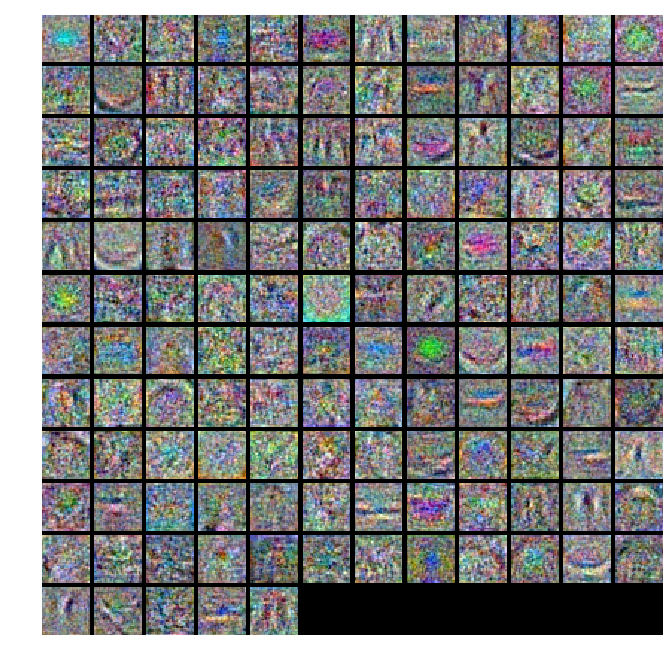

Test accuracy:  0.534


In [16]:
# Predict on the validation set
val_acc = (best_net.predict(X_val) == y_val).mean()
print 'Validation accuracy: ', val_acc
# plot our results
plot_loss_accuracy()
# visualize the weights of the best network
show_net_weights(best_net)

test_acc = (best_net.predict(X_test) == y_test).mean()
print 'Test accuracy: ', test_acc